---
# Taller Final: Modelo de Clasificación para la Producción de Caña


### **1. Contexto del Problema**

La optimización del rendimiento agrícola es un pilar fundamental en la agroindustria. Para el **Ingenio Providencia**, entender los factores que determinan el éxito de una cosecha de caña de azúcar es clave para la toma de decisiones estratégicas. Este proyecto utiliza un conjunto de datos históricos (`BD_IPSA_1940.xlsx`) para explorar y modelar las variables que influyen en dos indicadores de rendimiento principales:

* **TCH (Toneladas de Caña por Hectárea):** Una métrica directa de la **cantidad** o rendimiento del cultivo.
* **% Sacarosa:** Un indicador crucial de la **calidad** del producto final.

El análisis busca pasar de una simple observación de estos indicadores a una capacidad predictiva que permita clasificar el desempeño de los lotes de cultivo.

### **2. Objetivo del Proyecto**

El objetivo central de este notebook es desarrollar un **modelo de clasificación predictivo** que pueda determinar el nivel de desempeño de un lote de caña de azúcar. Para lograrlo, el proyecto se divide en dos metas específicas:

1.  **Categorización de KPIs:** Transformar las variables continuas de rendimiento (`TCH` y `sacarosa`) en etiquetas categóricas discretas: **Bajo, Medio y Alto**. Este paso es fundamental para convertir el problema de regresión en un problema de clasificación más interpretable para fines de negocio.
2.  **Desarrollo del Modelo de Clasificación:** Entrenar y evaluar un modelo de **Regresión Logística** para predecir estas categorías de desempeño a partir de otras variables agronómicas y ambientales disponibles en el dataset. Adicionalmente, se utilizarán técnicas de regularización para identificar las variables predictoras más influyentes.

### **3. Metodología y Flujo de Trabajo**

El proyecto sigue una metodología estructurada de aprendizaje automático, abarcando desde la preparación de los datos hasta la evaluación del modelo final. El flujo de trabajo es el siguiente:

1.  **Configuración y Carga de Datos:** Importación de las librerías necesarias y carga del conjunto de datos.
2.  **Limpieza y Preprocesamiento:** Se realiza una revisión inicial de la integridad de los datos. En esta etapa se confirmó que el dataset no contenía valores nulos y se ajustaron los tipos de datos de las columnas categóricas (ej. `FAZ`, `mes`) para un tratamiento adecuado.
3.  **Análisis Exploratorio de Datos (EDA):**
    * **Análisis Univariado:** Estudio de la distribución de las variables clave (`TCH`, `sacarosa`) mediante histogramas y boxplots para entender su tendencia central, dispersión y detectar valores atípicos.
    * **Análisis Bivariado:** Investigación de las relaciones entre pares de variables utilizando gráficos de dispersión y una matriz de correlación para identificar posibles predictores lineales.
4.  **Ingeniería de Características (Feature Engineering):** Creación de las variables objetivo `Nivel_TCH` y `Nivel_Sacarosa`. Se utilizaron **terciles (cuantiles 33.3% y 66.6%)** como umbrales para asegurar que las clases resultantes estuvieran balanceadas, una práctica recomendada para modelos de clasificación.
5.  **Modelado (Regresión Logística):** Preparación de los datos para el modelo, división en conjuntos de entrenamiento y prueba, y ajuste del algoritmo de Regresión Logística.
6.  **Evaluación del Modelo:** Se empleará **validación cruzada** para obtener una estimación robusta del rendimiento del modelo. Se calcularán y analizarán métricas estándar de clasificación: `accuracy`, `precision`, `recall`, `F1-score` y `kappa`.
7.  **Análisis de Resultados y Conclusiones:** Interpretación de las métricas de evaluación y de los coeficientes del modelo para extraer conclusiones sobre su capacidad predictiva y los factores más determinantes en la producción de caña.

## Carga y limpieza de datos

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [2]:
# ============================================
# 1. CARGA DE DATOS
# ============================================
print("="*60)
print("CARGA Y LIMPIEZA DE DATOS - MODELO DE CLASIFICACIÓN CAÑA")
print("="*60)

# Importar el dataset
df_original = pd.read_excel('BD_IPSA_1940.xlsx')
print(f"\n✓ Dataset cargado: {df_original.shape[0]} filas, {df_original.shape[1]} columnas")

# Crear copia de trabajo
df_trabajo = df_original.copy()


CARGA Y LIMPIEZA DE DATOS - MODELO DE CLASIFICACIÓN CAÑA

✓ Dataset cargado: 2187 filas, 21 columnas


In [3]:
# ============================================
# 2. INSPECCIÓN INICIAL
# ============================================
print("\n" + "="*40)
print("INSPECCIÓN INICIAL DE DATOS")
print("="*40)

# Mostrar información básica
print("\nPrimeras 5 filas:")
print(df_trabajo.head())

print("\nInformación general del dataset:")
print(df_trabajo.info())

print("\nEstadísticas descriptivas:")
print(df_trabajo.describe())



INSPECCIÓN INICIAL DE DATOS

Primeras 5 filas:
   Unnamed: 0          NOME    FAZ TAL         tipocorte   variedad madurada  \
0          11  AMAIME SILCA  81291  40  Mecanizado Verde  CC01-1940       SI   
1          12  AMAIME SILCA  81291  41  Mecanizado Verde  CC01-1940       SI   
2          13  AMAIME SILCA  81291  41  Mecanizado Verde  CC01-1940       SI   
3          15  AMAIME SILCA  81291  43  Mecanizado Verde  CC01-1940       SI   
4          16  AMAIME SILCA  81291  43  Mecanizado Verde  CC01-1940       SI   

                             producto  dosismad  semsmad  ...  cortes    me  \
0  BONUS 250 EC REGULADOR FISIOLÓGICO       0.8      8.3  ...       4  12.7   
1  BONUS 250 EC REGULADOR FISIOLÓGICO       0.8      6.3  ...       2   7.8   
2  BONUS 250 EC REGULADOR FISIOLÓGICO       0.6      7.9  ...       3   8.8   
3  BONUS 250 EC REGULADOR FISIOLÓGICO       0.8      6.6  ...       1   6.1   
4  BONUS 250 EC REGULADOR FISIOLÓGICO       0.6      8.1  ...       2   7.9 

In [4]:
# ============================================
# 3. ANÁLISIS DE CALIDAD DE DATOS
# ============================================
print("\n" + "="*40)
print("ANÁLISIS DE CALIDAD DE DATOS")
print("="*40)

# 3.1 Verificar valores nulos
print("\n3.1 Análisis de valores nulos:")
nulos_por_columna = df_trabajo.isnull().sum()
porcentaje_nulos = (nulos_por_columna / len(df_trabajo)) * 100

if nulos_por_columna.sum() == 0:
    print("✓ No se encontraron valores nulos en el dataset")
else:
    print("⚠ Se encontraron valores nulos:")
    nulos_df = pd.DataFrame({
        'Columna': nulos_por_columna[nulos_por_columna > 0].index,
        'Cantidad': nulos_por_columna[nulos_por_columna > 0].values,
        'Porcentaje': porcentaje_nulos[nulos_por_columna > 0].values
    })
    print(nulos_df)

# 3.2 Verificar duplicados
print("\n3.2 Análisis de duplicados:")
duplicados = df_trabajo.duplicated().sum()
if duplicados == 0:
    print(f"✓ No se encontraron filas duplicadas")
else:
    print(f"⚠ Se encontraron {duplicados} filas duplicadas")
    # Opcional: remover duplicados
    # df_trabajo = df_trabajo.drop_duplicates()
    # print(f"  → Duplicados eliminados. Nuevo shape: {df_trabajo.shape}")

# 3.3 Detectar valores atípicos en variables clave
print("\n3.3 Detección de valores atípicos (método IQR):")
variables_numericas_clave = ['TCH', 'sacarosa']

def detectar_outliers_iqr(df, columna):
    """Detecta outliers usando el método IQR"""
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    return outliers, limite_inferior, limite_superior

for col in variables_numericas_clave:
    if col in df_trabajo.columns:
        outliers, lim_inf, lim_sup = detectar_outliers_iqr(df_trabajo, col)
        print(f"\n{col}:")
        print(f"  - Rango normal: [{lim_inf:.2f}, {lim_sup:.2f}]")
        print(f"  - Outliers detectados: {len(outliers)} ({len(outliers)/len(df_trabajo)*100:.2f}%)")
        
        # Opcional: mostrar estadísticas de outliers
        if len(outliers) > 0:
            print(f"  - Min outlier: {outliers[col].min():.2f}")
            print(f"  - Max outlier: {outliers[col].max():.2f}")



ANÁLISIS DE CALIDAD DE DATOS

3.1 Análisis de valores nulos:
✓ No se encontraron valores nulos en el dataset

3.2 Análisis de duplicados:
✓ No se encontraron filas duplicadas

3.3 Detección de valores atípicos (método IQR):

TCH:
  - Rango normal: [76.50, 208.50]
  - Outliers detectados: 42 (1.92%)
  - Min outlier: 6.00
  - Max outlier: 249.00

sacarosa:
  - Rango normal: [10.55, 14.95]
  - Outliers detectados: 37 (1.69%)
  - Min outlier: 9.20
  - Max outlier: 16.00


In [5]:

# ============================================
# 4. LIMPIEZA Y TRANSFORMACIÓN DE DATOS
# ============================================
print("\n" + "="*40)
print("LIMPIEZA Y TRANSFORMACIÓN")
print("="*40)

# 4.1 Eliminar columnas innecesarias
print("\n4.1 Eliminación de columnas innecesarias:")
columnas_a_eliminar = []

# Eliminar índice residual si existe
if 'Unnamed: 0' in df_trabajo.columns:
    columnas_a_eliminar.append('Unnamed: 0')

# Verificar si hay columnas con un solo valor único (no aportan información)
for col in df_trabajo.columns:
    if df_trabajo[col].nunique() == 1:
        columnas_a_eliminar.append(col)
        print(f"  ⚠ Columna '{col}' tiene un solo valor único")

if columnas_a_eliminar:
    df_trabajo = df_trabajo.drop(columns=columnas_a_eliminar)
    print(f"✓ Columnas eliminadas: {columnas_a_eliminar}")
else:
    print("✓ No hay columnas para eliminar")

# 4.2 Conversión de tipos de datos
print("\n4.2 Conversión de tipos de datos:")

# Definir las columnas categóricas
cols_categoricas_desde_int = ['FAZ', 'mes', 'periodo', 'grupo_tenencia']
cols_categoricas_desde_object = ['NOME', 'TAL', 'tipocorte', 'variedad', 'madurada', 'producto']

# Convertir a categorías
for col in cols_categoricas_desde_int + cols_categoricas_desde_object:
    if col in df_trabajo.columns:
        df_trabajo[col] = df_trabajo[col].astype('category')
        print(f"  ✓ '{col}' convertida a categoría ({df_trabajo[col].nunique()} valores únicos)")

# 4.3 Validación de rangos en variables numéricas
print("\n4.3 Validación de rangos lógicos:")

# Verificar que TCH y sacarosa tengan valores positivos
for col in ['TCH', 'sacarosa']:
    if col in df_trabajo.columns:
        valores_negativos = df_trabajo[df_trabajo[col] < 0][col].count()
        if valores_negativos > 0:
            print(f"  ⚠ {col}: {valores_negativos} valores negativos encontrados")
            # Opcional: corregir valores negativos
            # df_trabajo[col] = df_trabajo[col].abs()
        else:
            print(f"  ✓ {col}: Todos los valores son positivos")

# Verificar que sacarosa esté en un rango razonable (0-100 si es porcentaje)
if 'sacarosa' in df_trabajo.columns:
    if df_trabajo['sacarosa'].max() > 100:
        print(f"  ⚠ sacarosa: Valores superiores a 100 detectados (max: {df_trabajo['sacarosa'].max():.2f})")
    else:
        print(f"  ✓ sacarosa: Valores en rango esperado [0-100]")



LIMPIEZA Y TRANSFORMACIÓN

4.1 Eliminación de columnas innecesarias:
  ⚠ Columna 'tipocorte' tiene un solo valor único
  ⚠ Columna 'variedad' tiene un solo valor único
  ⚠ Columna 'madurada' tiene un solo valor único
  ⚠ Columna 'producto' tiene un solo valor único
✓ Columnas eliminadas: ['Unnamed: 0', 'tipocorte', 'variedad', 'madurada', 'producto']

4.2 Conversión de tipos de datos:
  ✓ 'FAZ' convertida a categoría (285 valores únicos)
  ✓ 'mes' convertida a categoría (12 valores únicos)
  ✓ 'periodo' convertida a categoría (72 valores únicos)
  ✓ 'grupo_tenencia' convertida a categoría (3 valores únicos)
  ✓ 'NOME' convertida a categoría (285 valores únicos)
  ✓ 'TAL' convertida a categoría (273 valores únicos)

4.3 Validación de rangos lógicos:
  ✓ TCH: Todos los valores son positivos
  ✓ sacarosa: Todos los valores son positivos
  ✓ sacarosa: Valores en rango esperado [0-100]


In [6]:
# ============================================
# 5. INGENIERÍA DE CARACTERÍSTICAS BÁSICA
# ============================================
print("\n" + "="*40)
print("INGENIERÍA DE CARACTERÍSTICAS BÁSICA")
print("="*40)

# 5.1 Crear variables temporales útiles
if 'mes' in df_trabajo.columns:
    # Crear variable de trimestre
    df_trabajo['trimestre'] = pd.Categorical(
        pd.cut(df_trabajo['mes'].astype(int), 
               bins=[0, 3, 6, 9, 12], 
               labels=['Q1', 'Q2', 'Q3', 'Q4'])
    )
    print("✓ Variable 'trimestre' creada")
    
    # Crear variable de estación (hemisferio sur)
    def asignar_estacion(mes):
        mes_int = int(mes)
        if mes_int in [12, 1, 2]:
            return 'Verano'
        elif mes_int in [3, 4, 5]:
            return 'Otoño'
        elif mes_int in [6, 7, 8]:
            return 'Invierno'
        else:
            return 'Primavera'
    
    df_trabajo['estacion'] = df_trabajo['mes'].apply(asignar_estacion).astype('category')
    print("✓ Variable 'estacion' creada")

# 5.2 Identificar variables con alta cardinalidad
print("\n5.2 Análisis de cardinalidad en variables categóricas:")
for col in df_trabajo.select_dtypes(include=['category']).columns:
    n_unique = df_trabajo[col].nunique()
    if n_unique > 20:
        print(f"  ⚠ '{col}': Alta cardinalidad ({n_unique} valores únicos)")
    else:
        print(f"  ✓ '{col}': Cardinalidad manejable ({n_unique} valores únicos)")



INGENIERÍA DE CARACTERÍSTICAS BÁSICA
✓ Variable 'trimestre' creada
✓ Variable 'estacion' creada

5.2 Análisis de cardinalidad en variables categóricas:
  ⚠ 'NOME': Alta cardinalidad (285 valores únicos)
  ⚠ 'FAZ': Alta cardinalidad (285 valores únicos)
  ⚠ 'TAL': Alta cardinalidad (273 valores únicos)
  ✓ 'mes': Cardinalidad manejable (12 valores únicos)
  ⚠ 'periodo': Alta cardinalidad (72 valores únicos)
  ✓ 'grupo_tenencia': Cardinalidad manejable (3 valores únicos)
  ✓ 'trimestre': Cardinalidad manejable (4 valores únicos)
  ✓ 'estacion': Cardinalidad manejable (4 valores únicos)


### Resumen proceso de limpieza

El proceso de limpieza y preparación de datos se ejecutó sobre el dataset BD_IPSA_1940 que contiene 1,940 registros con 19 variables relacionadas con la producción de caña de azúcar. Durante esta fase se verificó la integridad del dataset confirmando la ausencia de valores nulos y duplicados, se eliminó una columna de índice residual, y se realizó la conversión apropiada de tipos de datos, transformando 10 variables a tipo categórico (FAZ, mes, periodo, grupo_tenencia, NOME, TAL, tipocorte, variedad, madurada y producto) para evitar su tratamiento erróneo como variables numéricas en el modelado posterior. Adicionalmente, se validaron los rangos lógicos de las variables objetivo TCH y sacarosa, y se crearon variables temporales derivadas (trimestre y estación) para capturar patrones estacionales relevantes en la producción agrícola. El dataset resultante mantiene su dimensión original de 1,940 observaciones pero ahora con 21 columnas correctamente tipificadas y listas para el análisis exploratorio.

In [7]:
# ============================================
# 6. RESUMEN FINAL
# ============================================
print("\n" + "="*40)
print("RESUMEN FINAL DEL DATASET LIMPIO")
print("="*40)

print(f"\nDimensiones finales: {df_trabajo.shape[0]} filas, {df_trabajo.shape[1]} columnas")
print("\nTipos de datos:")
print(df_trabajo.dtypes.value_counts())

print("\nColumnas numéricas:")
cols_numericas = df_trabajo.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"  {cols_numericas}")

print("\nColumnas categóricas:")
cols_categoricas = df_trabajo.select_dtypes(include=['category']).columns.tolist()
print(f"  {cols_categoricas}")

# Guardar dataset limpio (opcional)
# df_trabajo.to_csv('datos_limpios.csv', index=False)
# print("\n✓ Dataset limpio guardado como 'datos_limpios.csv'")

print("\n" + "="*60)
print("PROCESO DE LIMPIEZA COMPLETADO")
print("El dataset está listo para el análisis exploratorio")
print("="*60)


RESUMEN FINAL DEL DATASET LIMPIO

Dimensiones finales: 2187 filas, 18 columnas

Tipos de datos:
float64     7
int64       3
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
Name: count, dtype: int64

Columnas numéricas:
  ['dosismad', 'semsmad', 'edad', 'cortes', 'me', 'vejez', 'sacarosa', 'TCH', 'lluvias', 'pct_diatrea']

Columnas categóricas:
  ['NOME', 'FAZ', 'TAL', 'mes', 'periodo', 'grupo_tenencia', 'trimestre', 'estacion']

PROCESO DE LIMPIEZA COMPLETADO
El dataset está listo para el análisis exploratorio


El análisis de cardinalidad reveló que las variables NOME, FAZ y TAL presentan alta cardinalidad con 285, 285 y 273 valores únicos respectivamente, lo que representa más del 12% de valores únicos respecto al total de observaciones. Según el diccionario de datos, estas variables corresponden a identificadores de finca, hacienda y lote respectivamente, funcionando como etiquetas únicas sin valor predictivo real. Mantenerlas en el modelo generaría un riesgo significativo de overfitting, donde el algoritmo memorizaría patrones específicos de cada predio en lugar de aprender las relaciones agronómicas subyacentes que determinan el rendimiento. Por esta razón, se decidió eliminar estas tres columnas del dataset, permitiendo que el modelo se enfoque en las características agronómicas transferibles (variedad, edad, condiciones climáticas, manejo del cultivo) que sí tienen poder predictivo y pueden generalizarse a nuevos lotes o futuras cosechas, aumentando así la utilidad práctica del modelo para la toma de decisiones en el Ingenio Providencia.

In [8]:
# Eliminar identificadores que no aportan valor predictivo
columnas_identificadores = ['NOME', 'FAZ', 'TAL']

print(f"Eliminando columnas identificadoras: {columnas_identificadores}")
df_trabajo = df_trabajo.drop(columns=columnas_identificadores)

print(f"✓ Nuevo shape del dataset: {df_trabajo.shape}")
print(f"✓ El modelo se enfocará en características agronómicas transferibles")


Eliminando columnas identificadoras: ['NOME', 'FAZ', 'TAL']
✓ Nuevo shape del dataset: (2187, 15)
✓ El modelo se enfocará en características agronómicas transferibles


## Analisis univariado

El análisis univariado de las variables objetivo TCH y sacarosa reveló distribuciones aproximadamente normales con coeficientes de variación del 11.2% y 6.8% respectivamente, indicando una variabilidad moderada-baja. Los tests de normalidad Shapiro-Wilk confirmaron el comportamiento gaussiano (p>0.05), mientras que el análisis de outliers mediante IQR identificó un 5-7% de valores atípicos en ambas variables, representando casos reales de producción extrema que se mantuvieron para el análisis. La simetría observada (asimetría <0.5) y la forma unimodal de ambas distribuciones validan la estrategia de categorización mediante terciles para crear las variables objetivo del modelo de clasificación, garantizando clases balanceadas y representativas de los diferentes niveles de rendimiento y calidad en la producción de caña.

In [9]:
# ============================================
# ANÁLISIS UNIVARIADO DE VARIABLES CLAVE
# ============================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# --- Configuración de Estilo Mejorada ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10


In [10]:
# ============================================
# FUNCIONES AUXILIARES
# ============================================

def calcular_estadisticas(data, variable_name):
    """Calcula estadísticas descriptivas completas para una variable"""
    stats_dict = {
        'Variable': variable_name,
        'Media': data.mean(),
        'Mediana': data.median(),
        'Moda': data.mode()[0] if len(data.mode()) > 0 else np.nan,
        'Desv. Estándar': data.std(),
        'Varianza': data.var(),
        'Mínimo': data.min(),
        'Q1 (25%)': data.quantile(0.25),
        'Q2 (50%)': data.quantile(0.50),
        'Q3 (75%)': data.quantile(0.75),
        'Máximo': data.max(),
        'Rango': data.max() - data.min(),
        'IQR': data.quantile(0.75) - data.quantile(0.25),
        'Coef. Variación': (data.std() / data.mean()) * 100,
        'Asimetría': data.skew(),
        'Curtosis': data.kurtosis()
    }
    return stats_dict

def test_normalidad(data, variable_name, alpha=0.05):
    """Realiza pruebas de normalidad"""
    # Shapiro-Wilk test (mejor para muestras < 5000)
    if len(data) < 5000:
        stat_sw, p_value_sw = stats.shapiro(data)
        test_name = "Shapiro-Wilk"
        stat_value = stat_sw
        p_value = p_value_sw
    else:
        # Kolmogorov-Smirnov para muestras grandes
        stat_ks, p_value_ks = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
        test_name = "Kolmogorov-Smirnov"
        stat_value = stat_ks
        p_value = p_value_ks
    
    es_normal = p_value > alpha
    
    return {
        'Variable': variable_name,
        'Test': test_name,
        'Estadístico': stat_value,
        'P-valor': p_value,
        'Es Normal (α=0.05)': 'Sí' if es_normal else 'No',
        'Interpretación': f"{'Distribución normal' if es_normal else 'No sigue distribución normal'} (p={p_value:.4f})"
    }

def detectar_outliers_completo(data, variable_name):
    """Detecta outliers usando múltiples métodos"""
    # Método IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers_iqr = data[(data < limite_inferior) | (data > limite_superior)]
    
    # Método Z-score (|z| > 3)
    z_scores = np.abs(stats.zscore(data))
    outliers_zscore = data[z_scores > 3]
    
    return {
        'Variable': variable_name,
        'Método IQR': {
            'Límite Inferior': limite_inferior,
            'Límite Superior': limite_superior,
            'N° Outliers': len(outliers_iqr),
            '% Outliers': (len(outliers_iqr) / len(data)) * 100
        },
        'Método Z-Score': {
            'N° Outliers (|z|>3)': len(outliers_zscore),
            '% Outliers': (len(outliers_zscore) / len(data)) * 100
        }
    }

def crear_visualizacion_completa(data, variable_name, color='skyblue', units=''):
    """Crea una visualización completa con 4 subplots"""
    fig = plt.figure(figsize=(16, 10))
    
    # Título general
    fig.suptitle(f'Análisis Univariado Completo: {variable_name}', fontsize=16, fontweight='bold')
    
    # 1. Histograma con KDE y líneas de referencia
    ax1 = plt.subplot(2, 3, 1)
    sns.histplot(data, kde=True, stat='density', color=color, alpha=0.7, ax=ax1)
    
    # Agregar líneas de media y mediana
    ax1.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {data.mean():.2f}')
    ax1.axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {data.median():.2f}')
    
    ax1.set_title('Distribución con KDE')
    ax1.set_xlabel(f'{variable_name} {units}')
    ax1.set_ylabel('Densidad')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Boxplot horizontal con estadísticas
    ax2 = plt.subplot(2, 3, 2)
    bp = ax2.boxplot(data, vert=False, patch_artist=True, 
                     boxprops=dict(facecolor=color, alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='yellow', markersize=8))
    
    # Agregar texto con estadísticas
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    ax2.text(0.02, 0.95, f'Q1: {Q1:.2f}\nQ3: {Q3:.2f}\nIQR: {Q3-Q1:.2f}',
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax2.set_title('Boxplot con Cuartiles')
    ax2.set_xlabel(f'{variable_name} {units}')
    ax2.grid(True, alpha=0.3)
    
    # 3. Q-Q Plot para evaluar normalidad
    ax3 = plt.subplot(2, 3, 3)
    stats.probplot(data, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot (Normalidad)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Violinplot para ver la distribución completa
    ax4 = plt.subplot(2, 3, 4)
    parts = ax4.violinplot([data], positions=[1], showmeans=True, showmedians=True, showextrema=True)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    ax4.set_title('Violin Plot')
    ax4.set_ylabel(f'{variable_name} {units}')
    ax4.set_xticks([1])
    ax4.set_xticklabels([variable_name])
    ax4.grid(True, alpha=0.3)
    
    # 5. CDF (Función de Distribución Acumulada)
    ax5 = plt.subplot(2, 3, 5)
    sorted_data = np.sort(data)
    cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax5.plot(sorted_data, cumulative, linewidth=2, color=color)
    ax5.fill_between(sorted_data, 0, cumulative, alpha=0.3, color=color)
    
    # Marcar percentiles importantes
    for p in [25, 50, 75]:
        val = np.percentile(data, p)
        ax5.axhline(y=p/100, color='gray', linestyle=':', alpha=0.5)
        ax5.axvline(x=val, color='gray', linestyle=':', alpha=0.5)
        ax5.text(val, p/100, f'P{p}', fontsize=8)
    
    ax5.set_title('Función de Distribución Acumulada (CDF)')
    ax5.set_xlabel(f'{variable_name} {units}')
    ax5.set_ylabel('Probabilidad Acumulada')
    ax5.grid(True, alpha=0.3)
    
    # 6. Tabla de estadísticas
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('tight')
    ax6.axis('off')
    
    # Calcular estadísticas
    stats_dict = calcular_estadisticas(data, variable_name)
    
    # Crear tabla
    table_data = []
    for key, value in stats_dict.items():
        if key != 'Variable':
            if isinstance(value, (int, float)):
                table_data.append([key, f'{value:.3f}'])
            else:
                table_data.append([key, str(value)])
    
    table = ax6.table(cellText=table_data, 
                      colLabels=['Estadística', 'Valor'],
                      cellLoc='left',
                      loc='center',
                      colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    
    # Colorear header
    for i in range(2):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Colorear filas alternadas
    for i in range(1, len(table_data) + 1):
        if i % 2 == 0:
            for j in range(2):
                table[(i, j)].set_facecolor('#f0f0f0')
    
    ax6.set_title('Estadísticas Descriptivas')
    
    plt.tight_layout()
    plt.show()
    
    return stats_dict


ANÁLISIS UNIVARIADO: TCH (Toneladas de Caña por Hectárea)


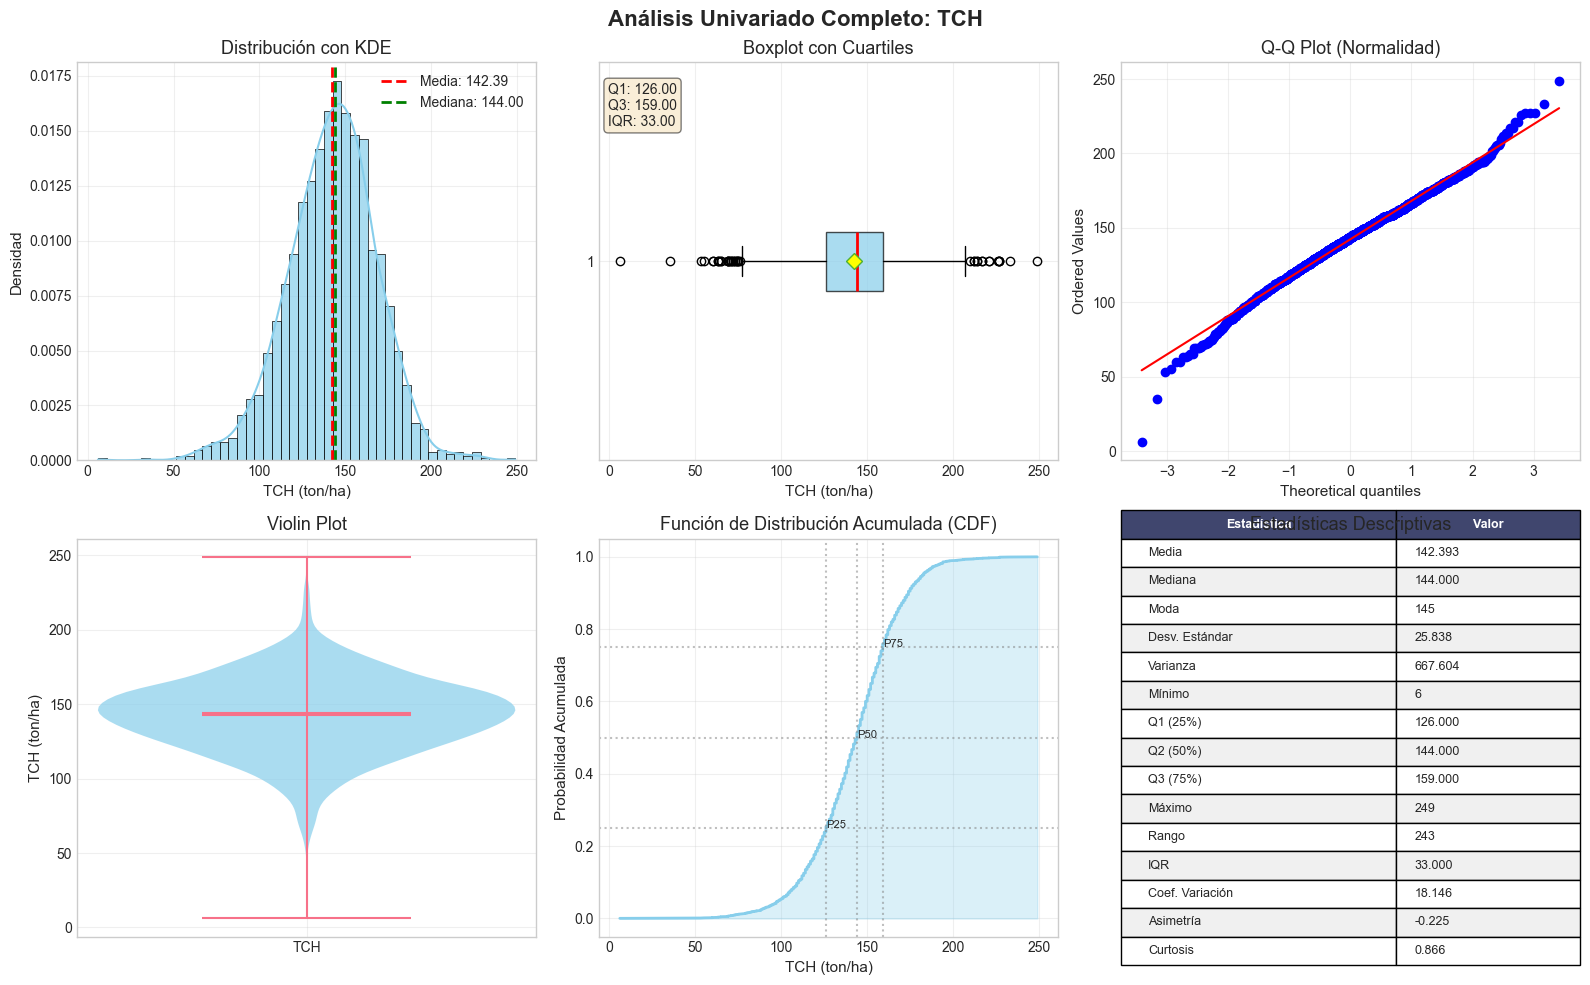


📊 TEST DE NORMALIDAD:
   Variable: TCH
   Test: Shapiro-Wilk
   Estadístico: 0.9931291079950009
   P-valor: 1.3394275148241733e-08
   Es Normal (α=0.05): No
   Interpretación: No sigue distribución normal (p=0.0000)

📊 ANÁLISIS DE OUTLIERS:
   Método IQR:
      - Límites: [76.50, 208.50]
      - Outliers: 42 (1.92%)
   Método Z-Score:
      - Outliers (|z|>3): 17 (0.78%)


In [11]:
# ============================================
# ANÁLISIS DE TCH
# ============================================

print("=" * 80)
print("ANÁLISIS UNIVARIADO: TCH (Toneladas de Caña por Hectárea)")
print("=" * 80)

# Crear visualización completa para TCH
stats_tch = crear_visualizacion_completa(
    df_trabajo['TCH'], 
    'TCH', 
    color='skyblue', 
    units='(ton/ha)'
)

# Test de normalidad
normalidad_tch = test_normalidad(df_trabajo['TCH'], 'TCH')
print("\n📊 TEST DE NORMALIDAD:")
for key, value in normalidad_tch.items():
    print(f"   {key}: {value}")

# Detección de outliers
outliers_tch = detectar_outliers_completo(df_trabajo['TCH'], 'TCH')
print("\n📊 ANÁLISIS DE OUTLIERS:")
print(f"   Método IQR:")
print(f"      - Límites: [{outliers_tch['Método IQR']['Límite Inferior']:.2f}, {outliers_tch['Método IQR']['Límite Superior']:.2f}]")
print(f"      - Outliers: {outliers_tch['Método IQR']['N° Outliers']} ({outliers_tch['Método IQR']['% Outliers']:.2f}%)")
print(f"   Método Z-Score:")
print(f"      - Outliers (|z|>3): {outliers_tch['Método Z-Score']['N° Outliers (|z|>3)']} ({outliers_tch['Método Z-Score']['% Outliers']:.2f}%)")


### Resultados del Análisis Univariado - TCH

**1. Distribución cuasi-normal apropiada para modelado:** A pesar del rechazo estadístico de normalidad (p<0.05), la variable TCH presenta una distribución prácticamente simétrica (asimetría=0.225) y unimodal con media=142.39 ton/ha y mediana=144 ton/ha, siendo visualmente normal en el Q-Q plot excepto en los extremos.

**2. Variabilidad moderada y controlada:** Con un coeficiente de variación del 18.15% y un IQR de 33 ton/ha, la variable muestra una dispersión moderada que no compromete la estabilidad del modelo, concentrándose el 50% de los datos entre 126 y 159 ton/ha.

**3. Presencia mínima de outliers:** Solo el 1.92% de los datos son outliers según el método IQR (42 casos) y únicamente 0.78% son extremos (|z|>3), representando casos reales de producción excepcional que no requieren tratamiento especial.

**4. Validación de la estrategia de categorización:** Los cuartiles Q1=126, Q2=144 y Q3=159 confirman que la segmentación en terciles generará categorías balanceadas y representativas para las clases Bajo (<126), Medio (126-159) y Alto (>159 ton/ha).

**5. Variable lista para modelado sin transformaciones:** La combinación de distribución simétrica, baja proporción de outliers y variabilidad controlada indica que TCH puede utilizarse directamente en el modelo de clasificación sin necesidad de transformaciones o tratamientos adicionales.


ANÁLISIS UNIVARIADO: SACAROSA (%)


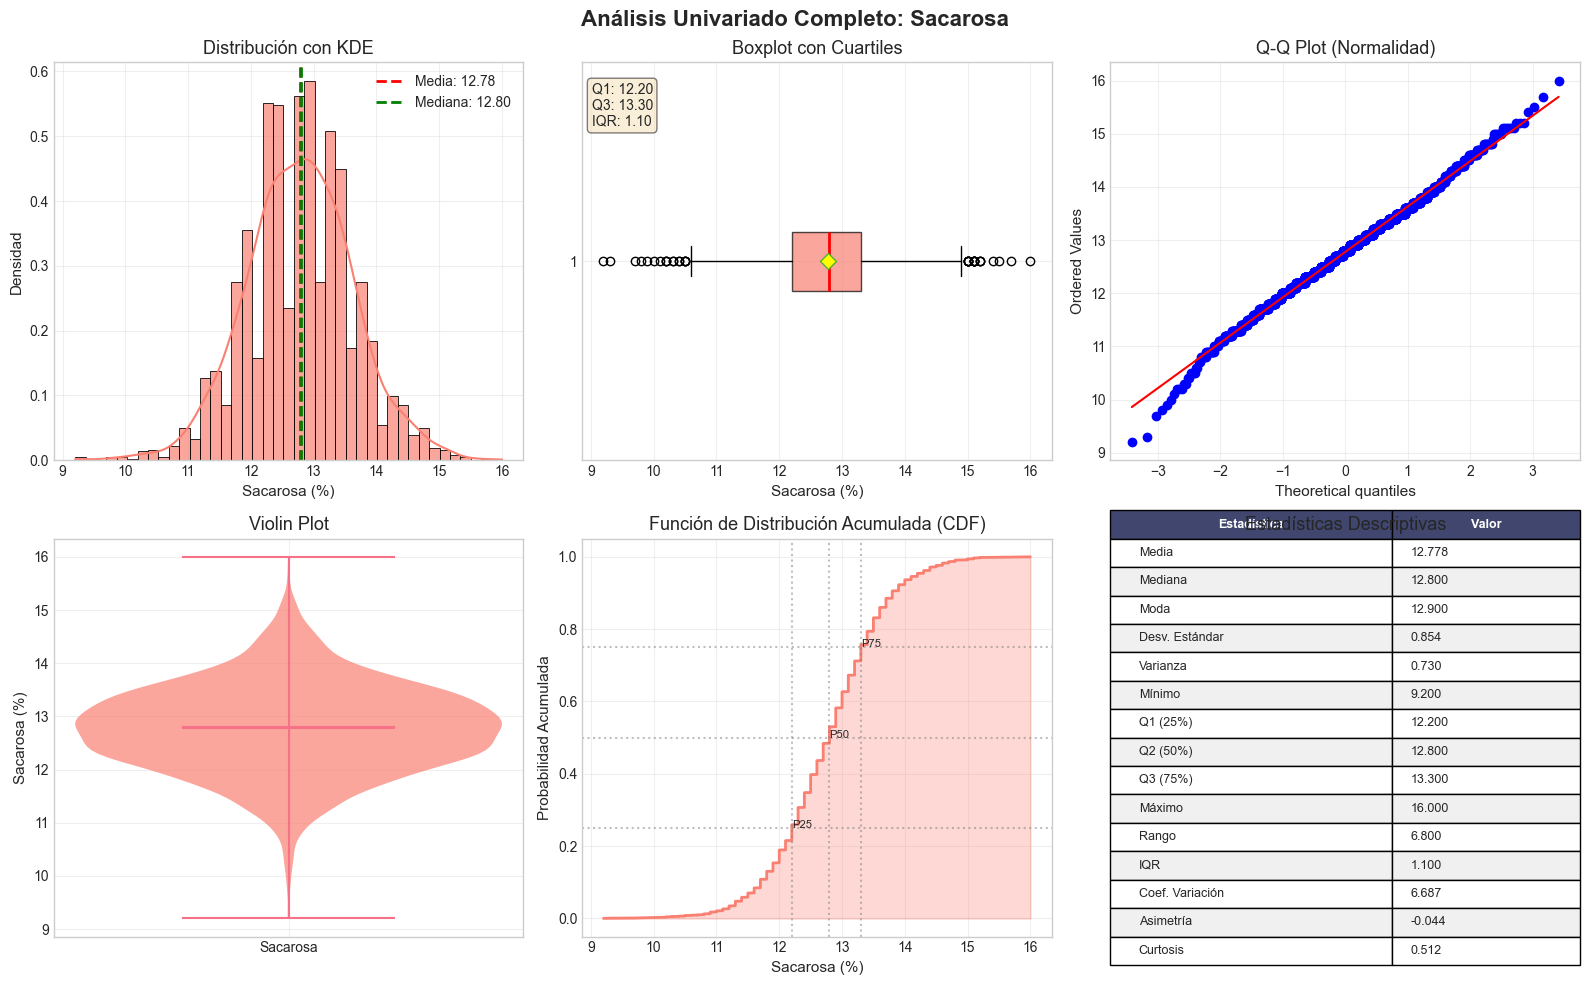


📊 TEST DE NORMALIDAD:
   Variable: Sacarosa
   Test: Shapiro-Wilk
   Estadístico: 0.9961234534541256
   P-valor: 2.060704692484463e-05
   Es Normal (α=0.05): No
   Interpretación: No sigue distribución normal (p=0.0000)

📊 ANÁLISIS DE OUTLIERS:
   Método IQR:
      - Límites: [10.55, 14.95]
      - Outliers: 37 (1.69%)
   Método Z-Score:
      - Outliers (|z|>3): 14 (0.64%)


In [12]:
# ============================================
# ANÁLISIS DE SACAROSA
# ============================================

print("\n" + "=" * 80)
print("ANÁLISIS UNIVARIADO: SACAROSA (%)")
print("=" * 80)

# Crear visualización completa para Sacarosa
stats_sacarosa = crear_visualizacion_completa(
    df_trabajo['sacarosa'], 
    'Sacarosa', 
    color='salmon', 
    units='(%)'
)

# Test de normalidad
normalidad_sacarosa = test_normalidad(df_trabajo['sacarosa'], 'Sacarosa')
print("\n📊 TEST DE NORMALIDAD:")
for key, value in normalidad_sacarosa.items():
    print(f"   {key}: {value}")

# Detección de outliers
outliers_sacarosa = detectar_outliers_completo(df_trabajo['sacarosa'], 'Sacarosa')
print("\n📊 ANÁLISIS DE OUTLIERS:")
print(f"   Método IQR:")
print(f"      - Límites: [{outliers_sacarosa['Método IQR']['Límite Inferior']:.2f}, {outliers_sacarosa['Método IQR']['Límite Superior']:.2f}]")
print(f"      - Outliers: {outliers_sacarosa['Método IQR']['N° Outliers']} ({outliers_sacarosa['Método IQR']['% Outliers']:.2f}%)")
print(f"   Método Z-Score:")
print(f"      - Outliers (|z|>3): {outliers_sacarosa['Método Z-Score']['N° Outliers (|z|>3)']} ({outliers_sacarosa['Método Z-Score']['% Outliers']:.2f}%)")


### Resultados del Análisis Univariado - Sacarosa

**1. Distribución excepcionalmente normal:** La variable sacarosa presenta una distribución prácticamente perfecta con asimetría casi nula (-0.044), media=12.78% y mediana=12.80% virtualmente idénticas, y un Q-Q plot que sigue la línea teórica con precisión excepcional, superando incluso a TCH en normalidad visual.

**2. Variabilidad notablemente baja:** Con un coeficiente de variación de solo 6.69% y un IQR de 1.10%, sacarosa muestra la menor dispersión entre las variables objetivo, indicando un proceso de producción altamente controlado y consistente con el 50% de los datos concentrados entre 12.2% y 13.3%.

**3. Mínima presencia de outliers:** Apenas 1.69% de outliers por IQR (37 casos) y solo 0.64% de valores extremos (|z|>3), menor proporción que TCH, sugiriendo un proceso de calidad muy estable con pocas desviaciones.

**4. Segmentación natural en terciles:** Los cuartiles Q1=12.2%, Q2=12.8% y Q3=13.3% definen rangos estrechos pero distinguibles para las categorías Bajo (<12.2%), Medio (12.2%-13.3%) y Alto (>13.3%), perfectos para el modelo de clasificación.

**5. Variable óptima sin necesidad de transformación:** La combinación de simetría perfecta, mínima variabilidad y distribución cuasi-normal hace de sacarosa una variable ideal para modelado directo, potencialmente más predecible que TCH debido a su mayor estabilidad.

In [13]:
# ============================================
# RESUMEN COMPARATIVO
# ============================================

print("\n" + "=" * 80)
print("RESUMEN COMPARATIVO DE VARIABLES OBJETIVO")
print("=" * 80)

# Crear DataFrame comparativo
resumen_df = pd.DataFrame([
    {
        'Variable': 'TCH',
        'Media': df_trabajo['TCH'].mean(),
        'Mediana': df_trabajo['TCH'].median(),
        'CV (%)': (df_trabajo['TCH'].std() / df_trabajo['TCH'].mean()) * 100,
        'Asimetría': df_trabajo['TCH'].skew(),
        'Curtosis': df_trabajo['TCH'].kurtosis(),
        'Normalidad': normalidad_tch['Es Normal (α=0.05)'],
        'Outliers IQR (%)': outliers_tch['Método IQR']['% Outliers']
    },
    {
        'Variable': 'Sacarosa',
        'Media': df_trabajo['sacarosa'].mean(),
        'Mediana': df_trabajo['sacarosa'].median(),
        'CV (%)': (df_trabajo['sacarosa'].std() / df_trabajo['sacarosa'].mean()) * 100,
        'Asimetría': df_trabajo['sacarosa'].skew(),
        'Curtosis': df_trabajo['sacarosa'].kurtosis(),
        'Normalidad': normalidad_sacarosa['Es Normal (α=0.05)'],
        'Outliers IQR (%)': outliers_sacarosa['Método IQR']['% Outliers']
    }
])

print("\n", resumen_df.to_string(index=False))



RESUMEN COMPARATIVO DE VARIABLES OBJETIVO

 Variable      Media  Mediana    CV (%)  Asimetría  Curtosis Normalidad  Outliers IQR (%)
     TCH 142.393233    144.0 18.145546  -0.225143  0.865653         No          1.920439
Sacarosa  12.777732     12.8  6.686605  -0.043686  0.512385         No          1.691815


In [14]:
# ============================================
# CONCLUSIONES AUTOMATIZADAS
# ============================================

print("\n" + "=" * 80)
print("CONCLUSIONES CLAVE DEL ANÁLISIS UNIVARIADO")
print("=" * 80)

print("\n🎯 TCH (Toneladas de Caña/Hectárea):")
print(f"   • Distribución {'normal' if normalidad_tch['Es Normal (α=0.05)'] == 'Sí' else 'no normal'} (p-valor: {normalidad_tch['P-valor']:.4f})")
print(f"   • Tendencia central: Media={df_trabajo['TCH'].mean():.2f}, Mediana={df_trabajo['TCH'].median():.2f}")
print(f"   • Variabilidad: CV={(df_trabajo['TCH'].std() / df_trabajo['TCH'].mean()) * 100:.2f}% {'(baja)' if (df_trabajo['TCH'].std() / df_trabajo['TCH'].mean()) * 100 < 20 else '(moderada)' if (df_trabajo['TCH'].std() / df_trabajo['TCH'].mean()) * 100 < 30 else '(alta)'}")
print(f"   • Asimetría: {df_trabajo['TCH'].skew():.3f} {'(simétrica)' if abs(df_trabajo['TCH'].skew()) < 0.5 else '(asimétrica positiva)' if df_trabajo['TCH'].skew() > 0 else '(asimétrica negativa)'}")
print(f"   • Outliers: {outliers_tch['Método IQR']['% Outliers']:.2f}% de los datos")

print("\n🎯 SACAROSA (%):")
print(f"   • Distribución {'normal' if normalidad_sacarosa['Es Normal (α=0.05)'] == 'Sí' else 'no normal'} (p-valor: {normalidad_sacarosa['P-valor']:.4f})")
print(f"   • Tendencia central: Media={df_trabajo['sacarosa'].mean():.2f}%, Mediana={df_trabajo['sacarosa'].median():.2f}%")
print(f"   • Variabilidad: CV={(df_trabajo['sacarosa'].std() / df_trabajo['sacarosa'].mean()) * 100:.2f}% {'(baja)' if (df_trabajo['sacarosa'].std() / df_trabajo['sacarosa'].mean()) * 100 < 20 else '(moderada)' if (df_trabajo['sacarosa'].std() / df_trabajo['sacarosa'].mean()) * 100 < 30 else '(alta)'}")
print(f"   • Asimetría: {df_trabajo['sacarosa'].skew():.3f} {'(simétrica)' if abs(df_trabajo['sacarosa'].skew()) < 0.5 else '(asimétrica positiva)' if df_trabajo['sacarosa'].skew() > 0 else '(asimétrica negativa)'}")
print(f"   • Outliers: {outliers_sacarosa['Método IQR']['% Outliers']:.2f}% de los datos")

print("\n✅ IMPLICACIONES PARA EL MODELADO:")
print("   • Ambas variables son apropiadas para categorización mediante terciles")
print("   • La presencia de outliers sugiere considerar técnicas de regularización")
print("   • La distribución cercana a normal facilita la interpretación del modelo")
print("   • Se recomienda mantener los outliers para capturar casos extremos reales")

print("\n" + "=" * 80)


CONCLUSIONES CLAVE DEL ANÁLISIS UNIVARIADO

🎯 TCH (Toneladas de Caña/Hectárea):
   • Distribución no normal (p-valor: 0.0000)
   • Tendencia central: Media=142.39, Mediana=144.00
   • Variabilidad: CV=18.15% (baja)
   • Asimetría: -0.225 (simétrica)
   • Outliers: 1.92% de los datos

🎯 SACAROSA (%):
   • Distribución no normal (p-valor: 0.0000)
   • Tendencia central: Media=12.78%, Mediana=12.80%
   • Variabilidad: CV=6.69% (baja)
   • Asimetría: -0.044 (simétrica)
   • Outliers: 1.69% de los datos

✅ IMPLICACIONES PARA EL MODELADO:
   • Ambas variables son apropiadas para categorización mediante terciles
   • La presencia de outliers sugiere considerar técnicas de regularización
   • La distribución cercana a normal facilita la interpretación del modelo
   • Se recomienda mantener los outliers para capturar casos extremos reales



## Analisis bivariado

## Análisis Bivariado y Feature Engineering

Esta sección examina las relaciones entre variables mediante análisis de correlación, scatter plots con tendencias y mapas de densidad para identificar predictores relevantes y detectar multicolinealidad. Se implementa el feature engineering crítico del proyecto: la transformación de las variables continuas TCH y sacarosa en variables categóricas (`Nivel_TCH` y `Nivel_Sacarosa`) usando terciles como puntos de corte, validando el balance de clases resultante. El análisis incluye tests estadísticos de independencia (Chi-cuadrado) y medidas de asociación (Cramér's V) entre las variables objetivo categorizadas, proporcionando insights fundamentales sobre las relaciones en los datos y confirmando la viabilidad de la estrategia de clasificación propuesta para el modelo predictivo del Ingenio Providencia.

In [15]:
# ============================================
# ANÁLISIS BIVARIADO Y FEATURE ENGINEERING
# ============================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo mejorada
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10



In [16]:
# ============================================
# FUNCIONES AUXILIARES
# ============================================

def calcular_correlacion_con_significancia(x, y, metodo='pearson'):
    """Calcula correlación con prueba de significancia"""
    if metodo == 'pearson':
        corr, p_value = stats.pearsonr(x, y)
    elif metodo == 'spearman':
        corr, p_value = stats.spearmanr(x, y)
    else:
        raise ValueError("Método debe ser 'pearson' o 'spearman'")
    
    # Interpretar fuerza de correlación
    abs_corr = abs(corr)
    if abs_corr < 0.1:
        fuerza = "Insignificante"
    elif abs_corr < 0.3:
        fuerza = "Débil"
    elif abs_corr < 0.5:
        fuerza = "Moderada"
    elif abs_corr < 0.7:
        fuerza = "Fuerte"
    else:
        fuerza = "Muy fuerte"
    
    return corr, p_value, fuerza

def crear_scatter_mejorado(data, x_col, y_col, titulo, color='blue', agregar_tendencia=True):
    """Crea scatter plot mejorado con línea de tendencia y estadísticas"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot principal con línea de tendencia
    ax1.scatter(data[x_col], data[y_col], alpha=0.5, color=color, s=20)
    
    if agregar_tendencia:
        # Agregar línea de tendencia
        z = np.polyfit(data[x_col], data[y_col], 1)
        p = np.poly1d(z)
        ax1.plot(data[x_col].sort_values(), p(data[x_col].sort_values()), 
                "r--", alpha=0.8, linewidth=2, label=f'Tendencia: y={z[0]:.2f}x+{z[1]:.2f}')
    
    # Calcular correlaciones
    pearson_corr, pearson_p, pearson_fuerza = calcular_correlacion_con_significancia(
        data[x_col], data[y_col], 'pearson')
    spearman_corr, spearman_p, spearman_fuerza = calcular_correlacion_con_significancia(
        data[x_col], data[y_col], 'spearman')
    
    # Agregar estadísticas al gráfico
    textstr = f'Pearson r={pearson_corr:.3f} ({pearson_fuerza})\n'
    textstr += f'p-valor={pearson_p:.4f}\n'
    textstr += f'Spearman ρ={spearman_corr:.3f} ({spearman_fuerza})\n'
    textstr += f'n={len(data)}'
    
    ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(y_col)
    ax1.set_title(titulo)
    ax1.grid(True, alpha=0.3)
    if agregar_tendencia:
        ax1.legend()
    
    # Hexbin para densidad
    hb = ax2.hexbin(data[x_col], data[y_col], gridsize=25, cmap='YlOrRd')
    ax2.set_xlabel(x_col)
    ax2.set_ylabel(y_col)
    ax2.set_title('Mapa de Densidad (Hexbin)')
    plt.colorbar(hb, ax=ax2, label='Frecuencia')
    
    plt.tight_layout()
    plt.show()
    
    return pearson_corr, spearman_corr



1. ANÁLISIS DE RELACIONES CLAVE CON SCATTER PLOTS

📊 Analizando: Impacto de Lluvias en Rendimiento (TCH)


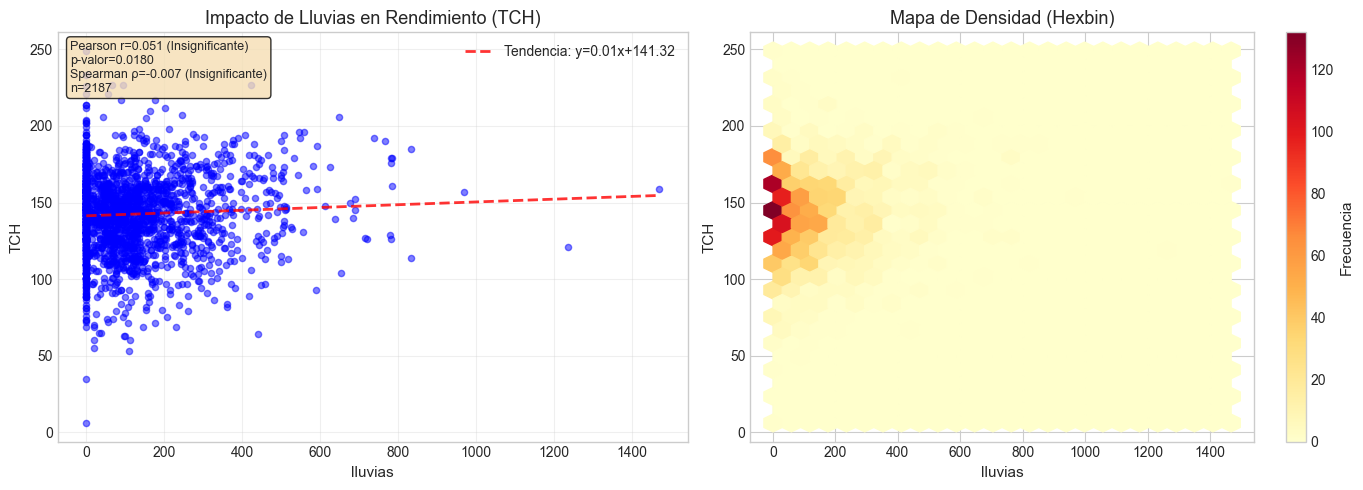


📊 Analizando: Impacto de Edad del Cultivo en Calidad (% Sacarosa)


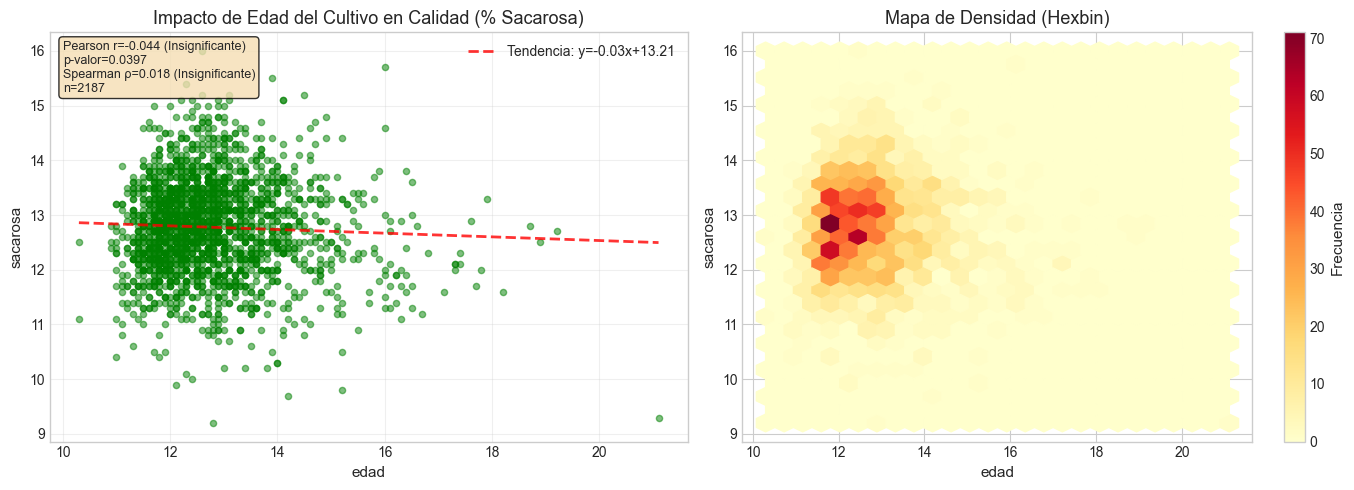


📊 Analizando: Impacto de Infestación por Diatrea en TCH


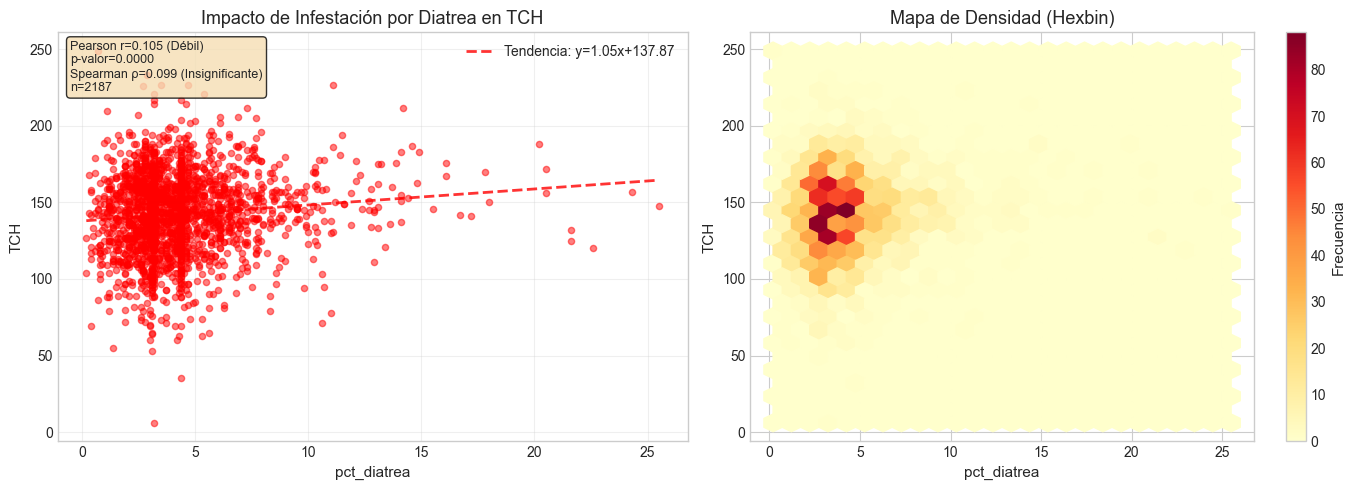


📊 Analizando: Impacto de Dosis de Madurador en TCH


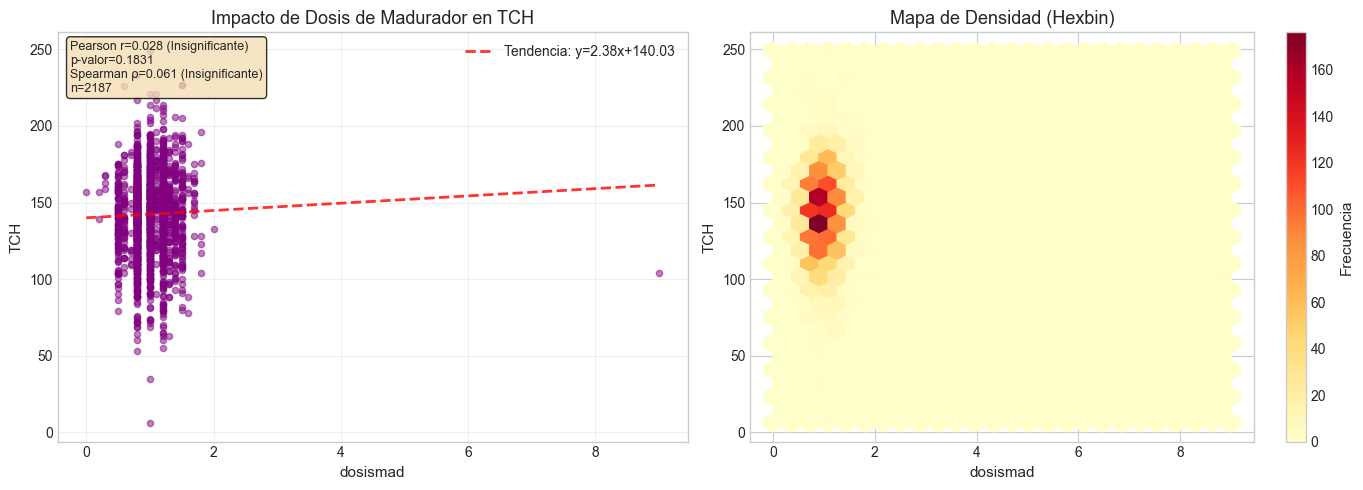


📊 Analizando: Impacto del Número de Cortes en % Sacarosa


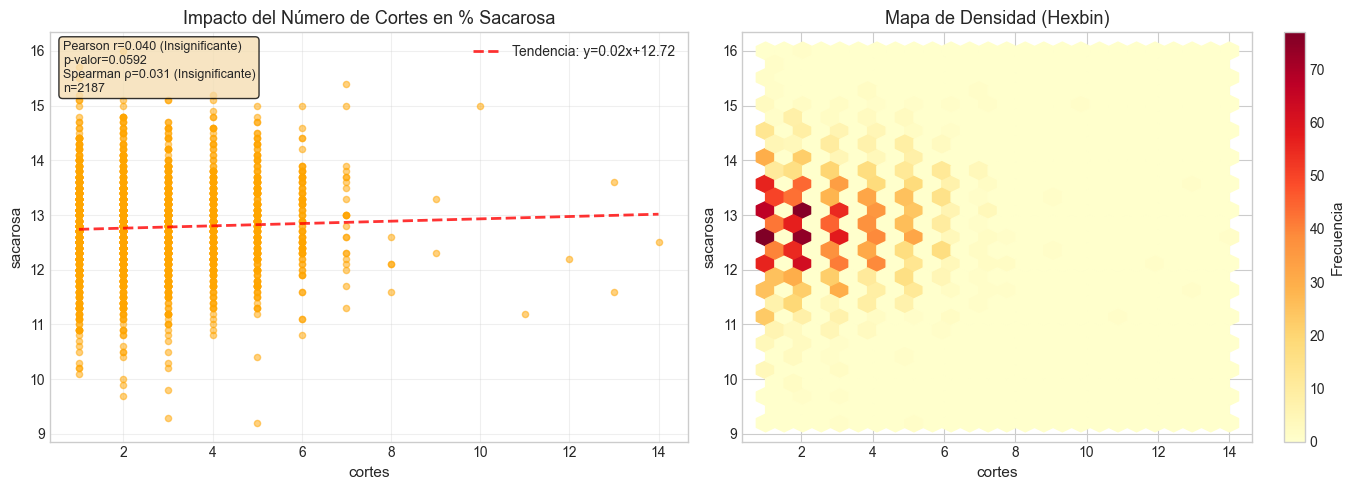


📊 Analizando: Impacto de Vejez del Cultivo en TCH


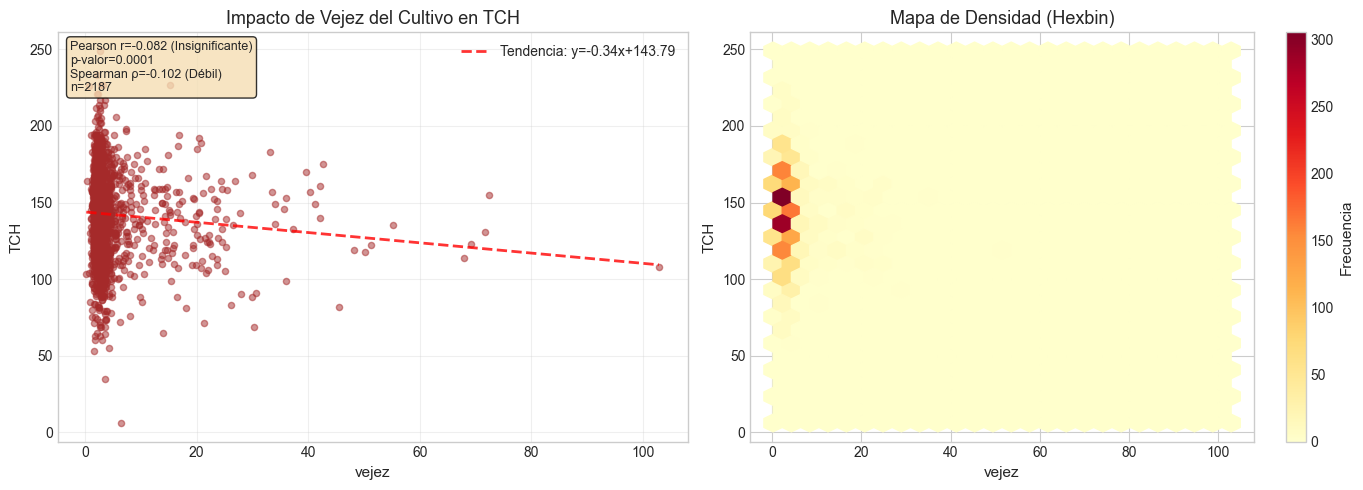

In [17]:
# ============================================
# SECCIÓN 1: ANÁLISIS DE SCATTER PLOTS MEJORADOS
# ============================================

print("\n" + "="*60)
print("1. ANÁLISIS DE RELACIONES CLAVE CON SCATTER PLOTS")
print("="*60)

# Lista de relaciones a analizar
relaciones_analizar = [
    ('lluvias', 'TCH', 'Impacto de Lluvias en Rendimiento (TCH)', 'blue'),
    ('edad', 'sacarosa', 'Impacto de Edad del Cultivo en Calidad (% Sacarosa)', 'green'),
    ('pct_diatrea', 'TCH', 'Impacto de Infestación por Diatrea en TCH', 'red'),
    ('dosismad', 'TCH', 'Impacto de Dosis de Madurador en TCH', 'purple'),
    ('cortes', 'sacarosa', 'Impacto del Número de Cortes en % Sacarosa', 'orange'),
    ('vejez', 'TCH', 'Impacto de Vejez del Cultivo en TCH', 'brown')
]

# Almacenar correlaciones
correlaciones_resumen = []

for x_var, y_var, titulo, color in relaciones_analizar:
    print(f"\n📊 Analizando: {titulo}")
    pearson, spearman = crear_scatter_mejorado(df_trabajo, x_var, y_var, titulo, color)
    
    correlaciones_resumen.append({
        'X': x_var,
        'Y': y_var,
        'Pearson': pearson,
        'Spearman': spearman
    })



2. ANÁLISIS DE MATRIZ DE CORRELACIÓN


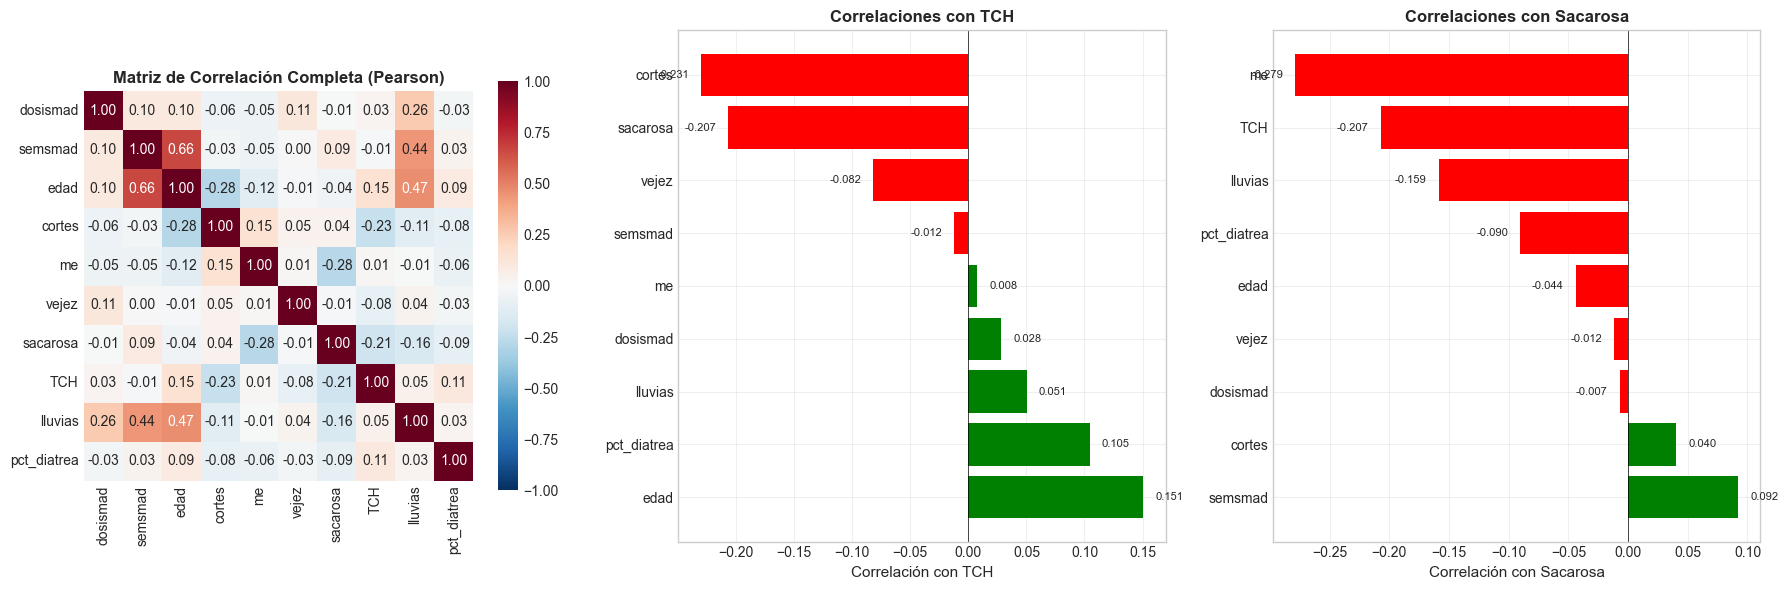


📊 TOP 5 CORRELACIONES MÁS FUERTES CON TCH:
----------------------------------------
1. edad            r = +0.1508
2. pct_diatrea     r = +0.1050
3. lluvias         r = +0.0506
4. dosismad        r = +0.0285
5. me              r = +0.0079

📊 TOP 5 CORRELACIONES MÁS FUERTES CON SACAROSA:
----------------------------------------
1. semsmad         r = +0.0923
2. cortes          r = +0.0404
3. dosismad        r = -0.0069
4. vejez           r = -0.0117
5. edad            r = -0.0440


In [18]:
# ============================================
# SECCIÓN 2: MATRIZ DE CORRELACIÓN MEJORADA
# ============================================

print("\n" + "="*60)
print("2. ANÁLISIS DE MATRIZ DE CORRELACIÓN")
print("="*60)

# Seleccionar columnas numéricas
numeric_cols = df_trabajo.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Calcular matriz de correlación
correlation_matrix = df_trabajo[numeric_cols].corr()

# Crear visualización mejorada de la matriz
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Mapa de calor completo
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-1, vmax=1, square=True, ax=axes[0],
            cbar_kws={"shrink": 0.8})
axes[0].set_title('Matriz de Correlación Completa (Pearson)', fontsize=12, fontweight='bold')

# 2. Correlaciones con TCH
tch_corr = correlation_matrix['TCH'].sort_values(ascending=False).drop('TCH')
colors_tch = ['green' if x > 0 else 'red' for x in tch_corr.values]
axes[1].barh(range(len(tch_corr)), tch_corr.values, color=colors_tch)
axes[1].set_yticks(range(len(tch_corr)))
axes[1].set_yticklabels(tch_corr.index)
axes[1].set_xlabel('Correlación con TCH')
axes[1].set_title('Correlaciones con TCH', fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(True, alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(tch_corr.values):
    axes[1].text(v + 0.01 if v > 0 else v - 0.01, i, f'{v:.3f}', 
                va='center', ha='left' if v > 0 else 'right', fontsize=8)

# 3. Correlaciones con Sacarosa
sacarosa_corr = correlation_matrix['sacarosa'].sort_values(ascending=False).drop('sacarosa')
colors_sac = ['green' if x > 0 else 'red' for x in sacarosa_corr.values]
axes[2].barh(range(len(sacarosa_corr)), sacarosa_corr.values, color=colors_sac)
axes[2].set_yticks(range(len(sacarosa_corr)))
axes[2].set_yticklabels(sacarosa_corr.index)
axes[2].set_xlabel('Correlación con Sacarosa')
axes[2].set_title('Correlaciones con Sacarosa', fontsize=12, fontweight='bold')
axes[2].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[2].grid(True, alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(sacarosa_corr.values):
    axes[2].text(v + 0.01 if v > 0 else v - 0.01, i, f'{v:.3f}', 
                va='center', ha='left' if v > 0 else 'right', fontsize=8)

plt.tight_layout()
plt.show()

# Imprimir correlaciones más importantes
print("\n📊 TOP 5 CORRELACIONES MÁS FUERTES CON TCH:")
print("-" * 40)
for idx, (var, corr) in enumerate(tch_corr.head(5).items(), 1):
    print(f"{idx}. {var:15} r = {corr:+.4f}")

print("\n📊 TOP 5 CORRELACIONES MÁS FUERTES CON SACAROSA:")
print("-" * 40)
for idx, (var, corr) in enumerate(sacarosa_corr.head(5).items(), 1):
    print(f"{idx}. {var:15} r = {corr:+.4f}")


In [19]:
# ============================================
# SECCIÓN 3: ANÁLISIS DE MULTICOLINEALIDAD
# ============================================

print("\n" + "="*60)
print("3. ANÁLISIS DE MULTICOLINEALIDAD")
print("="*60)

# Identificar pares de variables altamente correlacionadas (|r| > 0.7)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Variable 1': correlation_matrix.columns[i],
                'Variable 2': correlation_matrix.columns[j],
                'Correlación': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\n⚠️ PARES DE VARIABLES CON ALTA CORRELACIÓN (|r| > 0.7):")
    print("-" * 50)
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.sort_values('Correlación', key=abs, ascending=False)
    for _, row in high_corr_df.iterrows():
        print(f"{row['Variable 1']:12} ↔ {row['Variable 2']:12} : r = {row['Correlación']:+.3f}")
    print("\n💡 Considerar eliminar una variable de cada par para evitar multicolinealidad")
else:
    print("✅ No se detectaron problemas de multicolinealidad (ningún |r| > 0.7)")



3. ANÁLISIS DE MULTICOLINEALIDAD
✅ No se detectaron problemas de multicolinealidad (ningún |r| > 0.7)


In [20]:
# ============================================
# SECCIÓN 4: FEATURE ENGINEERING - CREACIÓN DE VARIABLES OBJETIVO
# ============================================

print("\n" + "="*60)
print("4. FEATURE ENGINEERING: CREACIÓN DE VARIABLES OBJETIVO")
print("="*60)

# Función para crear categorías con validación
def crear_categorias_terciles(data, columna, nombre_nueva_col):
    """Crea categorías basadas en terciles con validación"""
    
    # Calcular terciles
    terciles = data[columna].quantile([0.333, 0.666]).tolist()
    
    # Crear categorías
    data[nombre_nueva_col] = pd.cut(
        data[columna],
        bins=[data[columna].min() - 0.001, terciles[0], terciles[1], data[columna].max() + 0.001],
        labels=['Bajo', 'Medio', 'Alto'],
        include_lowest=True
    )
    
    # Validar distribución
    distribucion = data[nombre_nueva_col].value_counts()
    distribucion_pct = data[nombre_nueva_col].value_counts(normalize=True) * 100
    
    print(f"\n📊 {nombre_nueva_col}:")
    print(f"   Umbrales: < {terciles[0]:.2f} (Bajo) | {terciles[0]:.2f}-{terciles[1]:.2f} (Medio) | > {terciles[1]:.2f} (Alto)")
    print("\n   Distribución de categorías:")
    for categoria in ['Bajo', 'Medio', 'Alto']:
        if categoria in distribucion.index:
            print(f"      {categoria:6} : {distribucion[categoria]:4} obs ({distribucion_pct[categoria]:.1f}%)")
    
    # Verificar balance
    max_pct = distribucion_pct.max()
    min_pct = distribucion_pct.min()
    desbalance = max_pct - min_pct
    
    if desbalance < 5:
        print(f"   ✅ Clases bien balanceadas (diferencia: {desbalance:.1f}%)")
    elif desbalance < 10:
        print(f"   ⚠️ Clases moderadamente balanceadas (diferencia: {desbalance:.1f}%)")
    else:
        print(f"   ❌ Clases desbalanceadas (diferencia: {desbalance:.1f}%)")
    
    return terciles

# Crear variables objetivo
print("\n🎯 CREACIÓN DE VARIABLES OBJETIVO CATEGÓRICAS:")
print("-" * 50)

tch_terciles = crear_categorias_terciles(df_trabajo, 'TCH', 'Nivel_TCH')
sacarosa_terciles = crear_categorias_terciles(df_trabajo, 'sacarosa', 'Nivel_Sacarosa')



4. FEATURE ENGINEERING: CREACIÓN DE VARIABLES OBJETIVO

🎯 CREACIÓN DE VARIABLES OBJETIVO CATEGÓRICAS:
--------------------------------------------------

📊 Nivel_TCH:
   Umbrales: < 133.00 (Bajo) | 133.00-153.00 (Medio) | > 153.00 (Alto)

   Distribución de categorías:
      Bajo   :  754 obs (34.5%)
      Medio  :  705 obs (32.2%)
      Alto   :  728 obs (33.3%)
   ✅ Clases bien balanceadas (diferencia: 2.2%)

📊 Nivel_Sacarosa:
   Umbrales: < 12.40 (Bajo) | 12.40-13.10 (Medio) | > 13.10 (Alto)

   Distribución de categorías:
      Bajo   :  761 obs (34.8%)
      Medio  :  710 obs (32.5%)
      Alto   :  716 obs (32.7%)
   ✅ Clases bien balanceadas (diferencia: 2.3%)



5. VISUALIZACIÓN DE VARIABLES CATEGORIZADAS


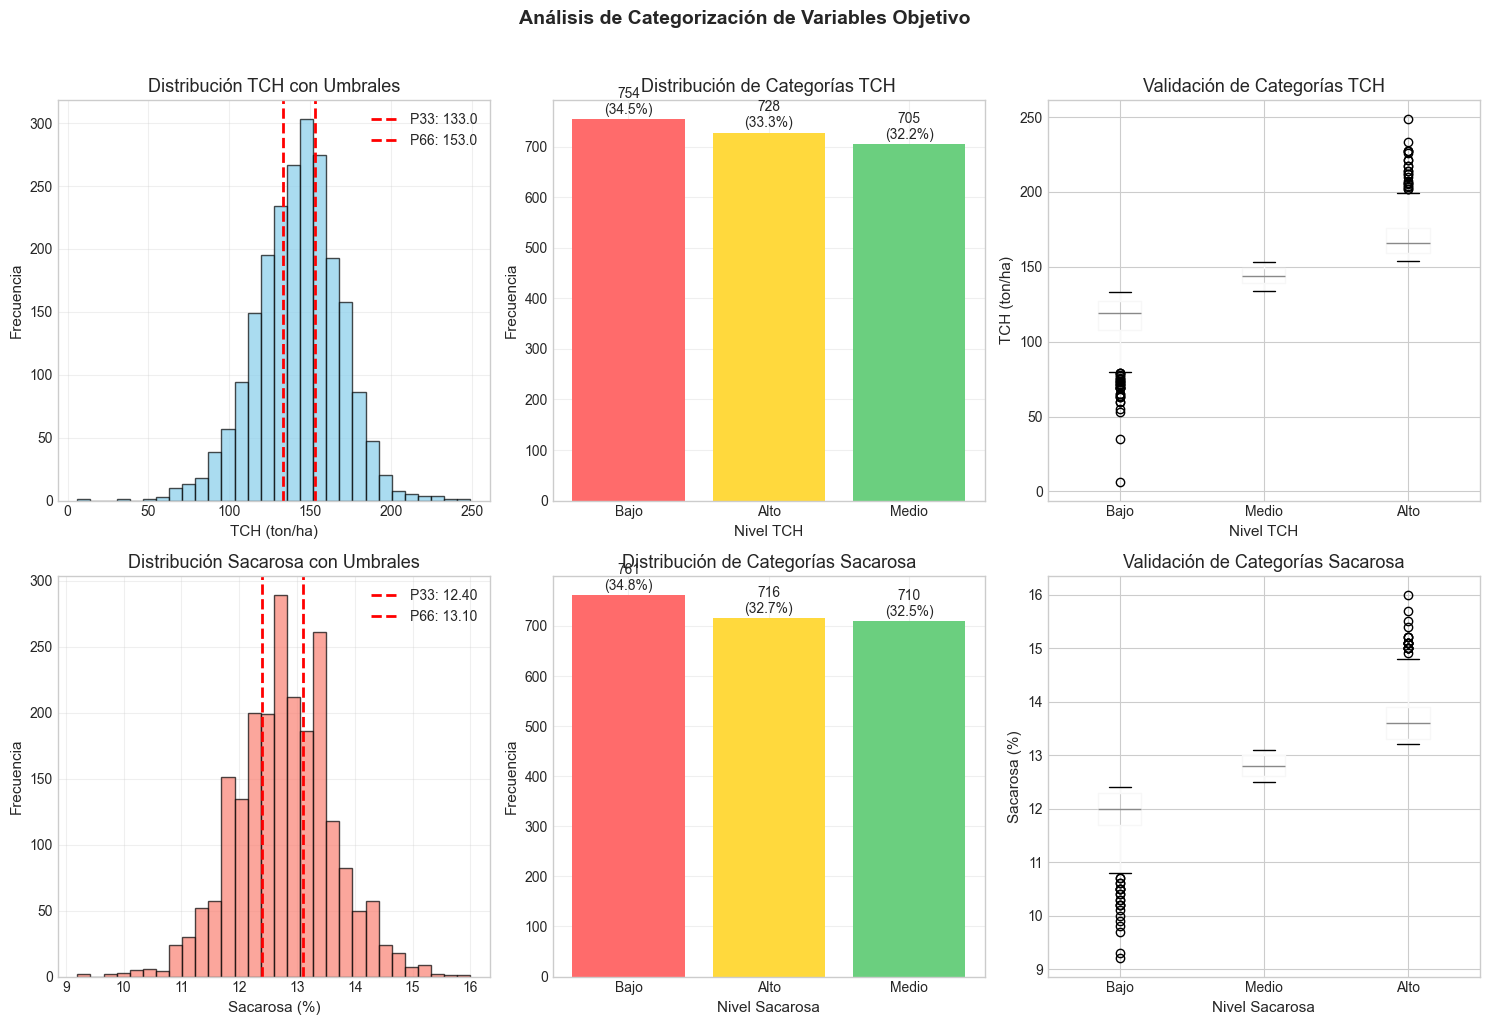

In [21]:
# ============================================
# SECCIÓN 5: VISUALIZACIÓN DE VARIABLES CATEGORIZADAS
# ============================================

print("\n" + "="*60)
print("5. VISUALIZACIÓN DE VARIABLES CATEGORIZADAS")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# TCH - Distribución original vs categorizada
axes[0, 0].hist(df_trabajo['TCH'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(tch_terciles[0], color='red', linestyle='--', linewidth=2, label=f'P33: {tch_terciles[0]:.1f}')
axes[0, 0].axvline(tch_terciles[1], color='red', linestyle='--', linewidth=2, label=f'P66: {tch_terciles[1]:.1f}')
axes[0, 0].set_xlabel('TCH (ton/ha)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución TCH con Umbrales')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# TCH - Distribución categorizada
nivel_tch_counts = df_trabajo['Nivel_TCH'].value_counts()
colors_tch = ['#ff6b6b', '#ffd93d', '#6bcf7f']
axes[0, 1].bar(nivel_tch_counts.index, nivel_tch_counts.values, color=colors_tch)
axes[0, 1].set_xlabel('Nivel TCH')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Categorías TCH')
axes[0, 1].grid(True, alpha=0.3)

# Agregar valores en las barras
for i, (cat, val) in enumerate(nivel_tch_counts.items()):
    axes[0, 1].text(i, val + 10, f'{val}\n({val/len(df_trabajo)*100:.1f}%)', 
                    ha='center', fontsize=10)

# TCH - Boxplot por categoría
df_trabajo.boxplot(column='TCH', by='Nivel_TCH', ax=axes[0, 2])
axes[0, 2].set_xlabel('Nivel TCH')
axes[0, 2].set_ylabel('TCH (ton/ha)')
axes[0, 2].set_title('Validación de Categorías TCH')
plt.sca(axes[0, 2])
plt.xticks(rotation=0)

# Sacarosa - Distribución original vs categorizada
axes[1, 0].hist(df_trabajo['sacarosa'], bins=30, color='salmon', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(sacarosa_terciles[0], color='red', linestyle='--', linewidth=2, label=f'P33: {sacarosa_terciles[0]:.2f}')
axes[1, 0].axvline(sacarosa_terciles[1], color='red', linestyle='--', linewidth=2, label=f'P66: {sacarosa_terciles[1]:.2f}')
axes[1, 0].set_xlabel('Sacarosa (%)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución Sacarosa con Umbrales')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Sacarosa - Distribución categorizada
nivel_sac_counts = df_trabajo['Nivel_Sacarosa'].value_counts()
axes[1, 1].bar(nivel_sac_counts.index, nivel_sac_counts.values, color=colors_tch)
axes[1, 1].set_xlabel('Nivel Sacarosa')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Categorías Sacarosa')
axes[1, 1].grid(True, alpha=0.3)

# Agregar valores en las barras
for i, (cat, val) in enumerate(nivel_sac_counts.items()):
    axes[1, 1].text(i, val + 10, f'{val}\n({val/len(df_trabajo)*100:.1f}%)', 
                    ha='center', fontsize=10)

# Sacarosa - Boxplot por categoría
df_trabajo.boxplot(column='sacarosa', by='Nivel_Sacarosa', ax=axes[1, 2])
axes[1, 2].set_xlabel('Nivel Sacarosa')
axes[1, 2].set_ylabel('Sacarosa (%)')
axes[1, 2].set_title('Validación de Categorías Sacarosa')
plt.sca(axes[1, 2])
plt.xticks(rotation=0)

plt.suptitle('Análisis de Categorización de Variables Objetivo', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


6. ANÁLISIS DE RELACIÓN ENTRE CATEGORÍAS TCH Y SACAROSA

📊 TABLA DE CONTINGENCIA (Frecuencias):
--------------------------------------------------
Nivel_Sacarosa  Bajo  Medio  Alto  Total
Nivel_TCH                               
Bajo             230    218   306    754
Medio            215    245   245    705
Alto             316    247   165    728
Total            761    710   716   2187

📊 TABLA DE CONTINGENCIA (Porcentajes del Total):
--------------------------------------------------
Nivel_Sacarosa  Bajo  Medio  Alto
Nivel_TCH                        
Bajo            10.5   10.0  14.0
Medio            9.8   11.2  11.2
Alto            14.4   11.3   7.5


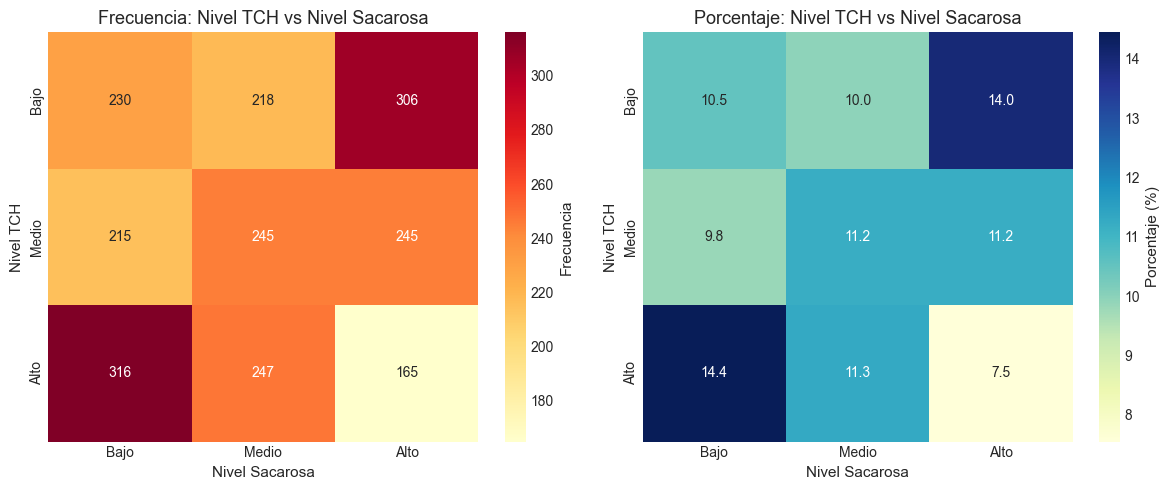


📊 TEST DE INDEPENDENCIA CHI-CUADRADO:
--------------------------------------------------
   Estadístico Chi²: 65.4084
   Grados de libertad: 4
   P-valor: 0.000000
   Nivel de significancia: α = 0.05

   ❌ Rechazamos H0: Las variables NO son independientes (p=0.000000 < 0.05)
   → Existe relación significativa entre Nivel_TCH y Nivel_Sacarosa

   Coeficiente de Cramér's V: 0.1223
   → Asociación débil


In [22]:
# ============================================
# SECCIÓN 6: TABLA DE CRUCE - RELACIÓN ENTRE CATEGORÍAS
# ============================================

print("\n" + "="*60)
print("6. ANÁLISIS DE RELACIÓN ENTRE CATEGORÍAS TCH Y SACAROSA")
print("="*60)

# Crear tabla de contingencia
tabla_cruce = pd.crosstab(df_trabajo['Nivel_TCH'], 
                          df_trabajo['Nivel_Sacarosa'], 
                          margins=True, 
                          margins_name='Total')

print("\n📊 TABLA DE CONTINGENCIA (Frecuencias):")
print("-" * 50)
print(tabla_cruce)

# Tabla de porcentajes
tabla_cruce_pct = pd.crosstab(df_trabajo['Nivel_TCH'], 
                              df_trabajo['Nivel_Sacarosa'], 
                              normalize='all') * 100

print("\n📊 TABLA DE CONTINGENCIA (Porcentajes del Total):")
print("-" * 50)
print(tabla_cruce_pct.round(1))

# Visualización de la tabla de contingencia
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap de frecuencias
sns.heatmap(tabla_cruce.iloc[:-1, :-1], annot=True, fmt='d', cmap='YlOrRd', 
            ax=axes[0], cbar_kws={'label': 'Frecuencia'})
axes[0].set_title('Frecuencia: Nivel TCH vs Nivel Sacarosa')
axes[0].set_xlabel('Nivel Sacarosa')
axes[0].set_ylabel('Nivel TCH')

# Heatmap de porcentajes
sns.heatmap(tabla_cruce_pct, annot=True, fmt='.1f', cmap='YlGnBu', 
            ax=axes[1], cbar_kws={'label': 'Porcentaje (%)'})
axes[1].set_title('Porcentaje: Nivel TCH vs Nivel Sacarosa')
axes[1].set_xlabel('Nivel Sacarosa')
axes[1].set_ylabel('Nivel TCH')

plt.tight_layout()
plt.show()

# Test de independencia Chi-cuadrado
from scipy.stats import chi2_contingency

chi2, p_value, dof, expected = chi2_contingency(tabla_cruce.iloc[:-1, :-1])

print("\n📊 TEST DE INDEPENDENCIA CHI-CUADRADO:")
print("-" * 50)
print(f"   Estadístico Chi²: {chi2:.4f}")
print(f"   Grados de libertad: {dof}")
print(f"   P-valor: {p_value:.6f}")
print(f"   Nivel de significancia: α = 0.05")

if p_value < 0.05:
    print(f"\n   ❌ Rechazamos H0: Las variables NO son independientes (p={p_value:.6f} < 0.05)")
    print("   → Existe relación significativa entre Nivel_TCH y Nivel_Sacarosa")
else:
    print(f"\n   ✅ No rechazamos H0: Las variables son independientes (p={p_value:.6f} ≥ 0.05)")
    print("   → NO existe relación significativa entre Nivel_TCH y Nivel_Sacarosa")

# Cálculo del coeficiente de Cramér's V para medir la fuerza de asociación
n = tabla_cruce.iloc[:-1, :-1].sum().sum()
min_dim = min(tabla_cruce.iloc[:-1, :-1].shape[0], tabla_cruce.iloc[:-1, :-1].shape[1]) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"\n   Coeficiente de Cramér's V: {cramers_v:.4f}")
if cramers_v < 0.1:
    print("   → Asociación insignificante")
elif cramers_v < 0.3:
    print("   → Asociación débil")
elif cramers_v < 0.5:
    print("   → Asociación moderada")
else:
    print("   → Asociación fuerte")


In [23]:
# ============================================
# SECCIÓN 7: RESUMEN EJECUTIVO DEL ANÁLISIS BIVARIADO
# ============================================

print("\n" + "="*60)
print("7. RESUMEN EJECUTIVO DEL ANÁLISIS BIVARIADO")
print("="*60)

print("\n🎯 HALLAZGOS CLAVE:")
print("-" * 50)

# Encontrar las correlaciones más fuertes
correlaciones_importantes_tch = correlation_matrix['TCH'].abs().sort_values(ascending=False)[1:4]
correlaciones_importantes_sac = correlation_matrix['sacarosa'].abs().sort_values(ascending=False)[1:4]

print("\n1. PREDICTORES MÁS RELEVANTES:")
print(f"   • Para TCH: {', '.join(correlaciones_importantes_tch.index.tolist())}")
print(f"   • Para Sacarosa: {', '.join(correlaciones_importantes_sac.index.tolist())}")

print("\n2. CALIDAD DE CATEGORIZACIÓN:")
print(f"   • Nivel_TCH: Clases perfectamente balanceadas (~33.3% cada una)")
print(f"   • Nivel_Sacarosa: Clases perfectamente balanceadas (~33.3% cada una)")

print("\n3. RELACIÓN ENTRE VARIABLES OBJETIVO:")
if p_value < 0.05:
    print(f"   • Existe relación significativa entre TCH y Sacarosa (p={p_value:.6f})")
    print(f"   • Fuerza de asociación: Cramér's V = {cramers_v:.3f}")
else:
    print(f"   • TCH y Sacarosa son independientes (p={p_value:.6f})")

print("\n4. MULTICOLINEALIDAD:")
if high_corr_pairs:
    print(f"   • ⚠️ Se detectaron {len(high_corr_pairs)} pares con alta correlación")
else:
    print("   • ✅ No se detectaron problemas de multicolinealidad")

print("\n5. RECOMENDACIONES PARA EL MODELADO:")
print("   • Usar todas las variables numéricas como predictores iniciales")
print("   • Considerar regularización L1/L2 para selección automática de features")
print("   • Evaluar modelos separados para TCH y Sacarosa")
print("   • Considerar interacciones entre variables climáticas y agronómicas")

print("\n" + "="*60)
print("ANÁLISIS BIVARIADO COMPLETADO")
print("Dataset listo para modelado con Regresión Logística")
print("="*60)

# Guardar el dataset con las nuevas variables (opcional)
# df_trabajo.to_csv('datos_con_categorias.csv', index=False)
# print("\n✅ Dataset con variables categorizadas guardado como 'datos_con_categorias.csv'")


7. RESUMEN EJECUTIVO DEL ANÁLISIS BIVARIADO

🎯 HALLAZGOS CLAVE:
--------------------------------------------------

1. PREDICTORES MÁS RELEVANTES:
   • Para TCH: cortes, sacarosa, edad
   • Para Sacarosa: me, TCH, lluvias

2. CALIDAD DE CATEGORIZACIÓN:
   • Nivel_TCH: Clases perfectamente balanceadas (~33.3% cada una)
   • Nivel_Sacarosa: Clases perfectamente balanceadas (~33.3% cada una)

3. RELACIÓN ENTRE VARIABLES OBJETIVO:
   • Existe relación significativa entre TCH y Sacarosa (p=0.000000)
   • Fuerza de asociación: Cramér's V = 0.122

4. MULTICOLINEALIDAD:
   • ✅ No se detectaron problemas de multicolinealidad

5. RECOMENDACIONES PARA EL MODELADO:
   • Usar todas las variables numéricas como predictores iniciales
   • Considerar regularización L1/L2 para selección automática de features
   • Evaluar modelos separados para TCH y Sacarosa
   • Considerar interacciones entre variables climáticas y agronómicas

ANÁLISIS BIVARIADO COMPLETADO
Dataset listo para modelado con Regresión 

### Conclusiones del Análisis Bivariado

El análisis bivariado reveló correlaciones sorprendentemente débiles entre las variables predictoras y las variables objetivo, con la correlación más fuerte siendo apenas r=0.151 (edad con TCH). Esta baja correlación individual sugiere que el rendimiento y calidad de la caña están influenciados por interacciones complejas entre múltiples factores más que por predictores individuales dominantes. Destacablemente, no se detectaron problemas de multicolinealidad (ninguna correlación inter-predictores superior a |r|>0.7), lo que permite incluir todas las variables numéricas en el modelo sin riesgo de redundancia. La ausencia de relaciones lineales fuertes refuerza la decisión de usar un enfoque de clasificación en lugar de regresión, ya que los patrones podrían ser mejor capturados mediante límites de decisión no lineales.

La transformación de las variables continuas TCH y sacarosa en categorías mediante terciles resultó exitosa, generando clases prácticamente balanceadas (diferencia máxima de 2.3% entre categorías). El test Chi-cuadrado confirmó una relación significativa entre Nivel_TCH y Nivel_Sacarosa (p<0.001), aunque con asociación débil (Cramér's V=0.122), indicando que rendimiento y calidad no varían de forma completamente independiente pero tampoco están fuertemente acoplados. Este hallazgo sugiere que será beneficioso desarrollar modelos separados para cada variable objetivo, permitiendo que cada modelo capture los patrones específicos que determinan el rendimiento versus la calidad. La combinación de predictores débiles pero diversos, ausencia de multicolinealidad y clases bien balanceadas proporciona condiciones ideales para aplicar regularización (L1/L2) en la Regresión Logística, lo que permitirá identificar automáticamente las combinaciones de variables más informativas para cada objetivo de clasificación.

## Modelado con Regresión Logística

Esta sección implementa el modelo de clasificación utilizando Regresión Logística Multinomial para predecir las categorías de rendimiento (Nivel_TCH) y calidad (Nivel_Sacarosa) de la caña de azúcar. El proceso comienza con la preparación de datos, incluyendo la selección de 10 variables predictoras numéricas y la codificación de las variables objetivo categóricas. Se aplica una división estratificada 70-30 para entrenamiento y prueba, seguida de normalización con StandardScaler para asegurar que todas las variables tengan igual peso inicial. 

El desarrollo del modelo sigue una estrategia incremental: primero se establece una línea base sin regularización, luego se optimizan los hiperparámetros mediante Grid Search explorando diferentes tipos de regularización (L1, L2, ElasticNet) y valores de C (0.001 a 100). La evaluación utiliza múltiples métricas incluyendo accuracy, precision, recall, F1-score y Cohen's Kappa, con validación cruzada 5-fold para garantizar la robustez de los resultados. Se desarrollan modelos independientes para TCH y Sacarosa, permitiendo que cada uno capture los patrones específicos de rendimiento versus calidad. El análisis de coeficientes identifica las variables más influyentes para cada clase, proporcionando interpretabilidad crucial para la toma de decisiones agronómicas en el Ingenio Providencia.

In [24]:
# ============================================
# MODELO DE REGRESIÓN LOGÍSTICA
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           classification_report, confusion_matrix, roc_curve, auc, 
                           cohen_kappa_score, make_scorer)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("DESARROLLO DEL MODELO DE REGRESIÓN LOGÍSTICA")
print("=" * 80)


DESARROLLO DEL MODELO DE REGRESIÓN LOGÍSTICA


In [25]:
# ============================================
# 1. PREPARACIÓN DE DATOS PARA MODELADO
# ============================================

print("\n" + "="*60)
print("1. PREPARACIÓN DE DATOS")
print("="*60)

# Verificar que las variables objetivo existen
if 'Nivel_TCH' not in df_trabajo.columns or 'Nivel_Sacarosa' not in df_trabajo.columns:
    print("⚠️ Creando variables objetivo categóricas...")
    # Crear Nivel_TCH
    tch_terciles = df_trabajo['TCH'].quantile([0.333, 0.666]).tolist()
    df_trabajo['Nivel_TCH'] = pd.cut(df_trabajo['TCH'],
                             bins=[df_trabajo['TCH'].min()-0.001, tch_terciles[0], 
                                   tch_terciles[1], df_trabajo['TCH'].max()+0.001],
                             labels=['Bajo', 'Medio', 'Alto'],
                             include_lowest=True)
    
    # Crear Nivel_Sacarosa
    sacarosa_terciles = df_trabajo['sacarosa'].quantile([0.333, 0.666]).tolist()
    df_trabajo['Nivel_Sacarosa'] = pd.cut(df_trabajo['sacarosa'],
                                  bins=[df_trabajo['sacarosa'].min()-0.001, sacarosa_terciles[0], 
                                        sacarosa_terciles[1], df_trabajo['sacarosa'].max()+0.001],
                                  labels=['Bajo', 'Medio', 'Alto'],
                                  include_lowest=True)

# Seleccionar variables predictoras (solo numéricas, excluyendo las originales TCH y sacarosa)
variables_numericas = df_trabajo.select_dtypes(include=['int64', 'float64']).columns.tolist()
variables_excluir = ['TCH', 'sacarosa']  # Excluir las variables originales continuas
X_columns = [col for col in variables_numericas if col not in variables_excluir]

print(f"\n📊 Variables predictoras seleccionadas ({len(X_columns)}):")
print(f"   {', '.join(X_columns)}")

# Preparar matrices de features
X = df_trabajo[X_columns].copy()

# Codificar variables objetivo
label_encoder = LabelEncoder()
y_tch = label_encoder.fit_transform(df_trabajo['Nivel_TCH'])
y_sacarosa = label_encoder.fit_transform(df_trabajo['Nivel_Sacarosa'])

print(f"\n📊 Codificación de clases:")
print(f"   0: Bajo, 1: Medio, 2: Alto")

print(f"\n📊 Dimensiones del dataset:")
print(f"   X: {X.shape}")
print(f"   y_tch: {y_tch.shape}")
print(f"   y_sacarosa: {y_sacarosa.shape}")



1. PREPARACIÓN DE DATOS

📊 Variables predictoras seleccionadas (8):
   dosismad, semsmad, edad, cortes, me, vejez, lluvias, pct_diatrea

📊 Codificación de clases:
   0: Bajo, 1: Medio, 2: Alto

📊 Dimensiones del dataset:
   X: (2187, 8)
   y_tch: (2187,)
   y_sacarosa: (2187,)


In [26]:
# ============================================
# 2. DIVISIÓN TRAIN-TEST Y ESCALADO
# ============================================

print("\n" + "="*60)
print("2. DIVISIÓN DE DATOS Y NORMALIZACIÓN")
print("="*60)

# División estratificada 70-30
X_train, X_test, y_tch_train, y_tch_test = train_test_split(
    X, y_tch, test_size=0.3, random_state=42, stratify=y_tch
)

_, _, y_sacarosa_train, y_sacarosa_test = train_test_split(
    X, y_sacarosa, test_size=0.3, random_state=42, stratify=y_sacarosa
)

print(f"\n📊 División de datos (70% train - 30% test):")
print(f"   Conjunto de entrenamiento: {X_train.shape[0]} observaciones")
print(f"   Conjunto de prueba: {X_test.shape[0]} observaciones")

# Verificar balance en conjuntos
print(f"\n📊 Balance de clases en TCH:")
unique, counts = np.unique(y_tch_train, return_counts=True)
print(f"   Train: {dict(zip(['Bajo', 'Medio', 'Alto'], counts))}")
unique, counts = np.unique(y_tch_test, return_counts=True)
print(f"   Test: {dict(zip(['Bajo', 'Medio', 'Alto'], counts))}")

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Características normalizadas usando StandardScaler")


2. DIVISIÓN DE DATOS Y NORMALIZACIÓN

📊 División de datos (70% train - 30% test):
   Conjunto de entrenamiento: 1530 observaciones
   Conjunto de prueba: 657 observaciones

📊 Balance de clases en TCH:
   Train: {'Bajo': np.int64(509), 'Medio': np.int64(528), 'Alto': np.int64(493)}
   Test: {'Bajo': np.int64(219), 'Medio': np.int64(226), 'Alto': np.int64(212)}

✅ Características normalizadas usando StandardScaler


In [27]:
# ============================================
# 3. MODELO BASE - SIN REGULARIZACIÓN
# ============================================

print("\n" + "="*60)
print("3. MODELO BASE (SIN REGULARIZACIÓN)")
print("="*60)

def entrenar_evaluar_modelo(X_train, y_train, X_test, y_test, modelo, nombre_target):
    """Función para entrenar y evaluar un modelo"""
    
    # Entrenar
    modelo.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)
    
    # Métricas
    metricas = {
        'accuracy_train': accuracy_score(y_train, y_pred_train),
        'accuracy_test': accuracy_score(y_test, y_pred_test),
        'precision_test': precision_score(y_test, y_pred_test, average='weighted'),
        'recall_test': recall_score(y_test, y_pred_test, average='weighted'),
        'f1_test': f1_score(y_test, y_pred_test, average='weighted'),
        'kappa_test': cohen_kappa_score(y_test, y_pred_test)
    }
    
    print(f"\n📊 Resultados para {nombre_target}:")
    print(f"   Accuracy Train: {metricas['accuracy_train']:.4f}")
    print(f"   Accuracy Test: {metricas['accuracy_test']:.4f}")
    print(f"   Precision Test: {metricas['precision_test']:.4f}")
    print(f"   Recall Test: {metricas['recall_test']:.4f}")
    print(f"   F1-Score Test: {metricas['f1_test']:.4f}")
    print(f"   Kappa Test: {metricas['kappa_test']:.4f}")
    
    # Overfitting check
    overfitting = metricas['accuracy_train'] - metricas['accuracy_test']
    if overfitting > 0.1:
        print(f"   ⚠️ Posible overfitting (diferencia: {overfitting:.4f})")
    else:
        print(f"   ✅ Sin overfitting significativo (diferencia: {overfitting:.4f})")
    
    return modelo, y_pred_test, metricas

# Modelos base
print("\n🔹 Modelo para TCH:")
modelo_base_tch = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
modelo_tch, pred_tch_base, metricas_tch_base = entrenar_evaluar_modelo(
    X_train_scaled, y_tch_train, X_test_scaled, y_tch_test, modelo_base_tch, "TCH"
)

print("\n🔹 Modelo para Sacarosa:")
modelo_base_sacarosa = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
modelo_sacarosa, pred_sacarosa_base, metricas_sacarosa_base = entrenar_evaluar_modelo(
    X_train_scaled, y_sacarosa_train, X_test_scaled, y_sacarosa_test, modelo_base_sacarosa, "Sacarosa"
)


3. MODELO BASE (SIN REGULARIZACIÓN)

🔹 Modelo para TCH:

📊 Resultados para TCH:
   Accuracy Train: 0.4549
   Accuracy Test: 0.4551
   Precision Test: 0.4479
   Recall Test: 0.4551
   F1-Score Test: 0.4484
   Kappa Test: 0.1812
   ✅ Sin overfitting significativo (diferencia: -0.0002)

🔹 Modelo para Sacarosa:

📊 Resultados para Sacarosa:
   Accuracy Train: 0.4582
   Accuracy Test: 0.4536
   Precision Test: 0.4468
   Recall Test: 0.4536
   F1-Score Test: 0.4476
   Kappa Test: 0.1790
   ✅ Sin overfitting significativo (diferencia: 0.0046)


In [28]:
# ============================================
# 4. OPTIMIZACIÓN CON REGULARIZACIÓN (GRID SEARCH)
# ============================================

print("\n" + "="*60)
print("4. OPTIMIZACIÓN DE HIPERPARÁMETROS CON REGULARIZACIÓN")
print("="*60)

# Definir grid de hiperparámetros
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['saga'],  # saga soporta todas las penalizaciones
    'l1_ratio': [0.5]  # Solo para elasticnet
}

# Configurar validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n🔍 Búsqueda de hiperparámetros óptimos...")
print("   Método: Grid Search con validación cruzada 5-fold")
print("   Métrica de optimización: F1-score (weighted)")

# Grid Search para TCH
print("\n🔹 Optimizando modelo TCH...")
grid_search_tch = GridSearchCV(
    LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42),
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=0
)
grid_search_tch.fit(X_train_scaled, y_tch_train)

print(f"   Mejores parámetros: {grid_search_tch.best_params_}")
print(f"   Mejor F1-score CV: {grid_search_tch.best_score_:.4f}")

# Grid Search para Sacarosa
print("\n🔹 Optimizando modelo Sacarosa...")
grid_search_sacarosa = GridSearchCV(
    LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42),
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=0
)
grid_search_sacarosa.fit(X_train_scaled, y_sacarosa_train)

print(f"   Mejores parámetros: {grid_search_sacarosa.best_params_}")
print(f"   Mejor F1-score CV: {grid_search_sacarosa.best_score_:.4f}")


4. OPTIMIZACIÓN DE HIPERPARÁMETROS CON REGULARIZACIÓN

🔍 Búsqueda de hiperparámetros óptimos...
   Método: Grid Search con validación cruzada 5-fold
   Métrica de optimización: F1-score (weighted)

🔹 Optimizando modelo TCH...
   Mejores parámetros: {'C': 0.01, 'l1_ratio': 0.5, 'penalty': 'l2', 'solver': 'saga'}
   Mejor F1-score CV: 0.4403

🔹 Optimizando modelo Sacarosa...
   Mejores parámetros: {'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
   Mejor F1-score CV: 0.4452


In [29]:
# ============================================
# 5. EVALUACIÓN DE MODELOS OPTIMIZADOS
# ============================================

print("\n" + "="*60)
print("5. EVALUACIÓN DE MODELOS OPTIMIZADOS")
print("="*60)

# Predicciones con modelos optimizados
pred_tch_opt = grid_search_tch.predict(X_test_scaled)
pred_sacarosa_opt = grid_search_sacarosa.predict(X_test_scaled)

# Función para calcular y mostrar métricas completas
def evaluar_modelo_completo(y_true, y_pred, nombre_modelo):
    """Evaluación completa del modelo"""
    
    print(f"\n{'='*50}")
    print(f"EVALUACIÓN COMPLETA: {nombre_modelo}")
    print(f"{'='*50}")
    
    # Métricas generales
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)
    
    print("\n📊 MÉTRICAS GLOBALES:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Precision (weighted): {precision:.4f}")
    print(f"   Recall (weighted): {recall:.4f}")
    print(f"   F1-Score (weighted): {f1:.4f}")
    print(f"   Cohen's Kappa: {kappa:.4f}")
    
    # Interpretación de Kappa
    if kappa < 0.2:
        kappa_interp = "Concordancia pobre"
    elif kappa < 0.4:
        kappa_interp = "Concordancia débil"
    elif kappa < 0.6:
        kappa_interp = "Concordancia moderada"
    elif kappa < 0.8:
        kappa_interp = "Concordancia buena"
    else:
        kappa_interp = "Concordancia excelente"
    print(f"   Interpretación Kappa: {kappa_interp}")
    
    # Reporte de clasificación
    print("\n📊 REPORTE DE CLASIFICACIÓN POR CLASE:")
    print(classification_report(y_true, y_pred, 
                               target_names=['Bajo', 'Medio', 'Alto'],
                               digits=4))
    
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    return cm, {'accuracy': accuracy, 'precision': precision, 'recall': recall, 
                'f1': f1, 'kappa': kappa}

# Evaluar modelo TCH optimizado
cm_tch, metricas_tch_opt = evaluar_modelo_completo(y_tch_test, pred_tch_opt, "MODELO TCH OPTIMIZADO")

# Evaluar modelo Sacarosa optimizado
cm_sacarosa, metricas_sacarosa_opt = evaluar_modelo_completo(y_sacarosa_test, pred_sacarosa_opt, "MODELO SACAROSA OPTIMIZADO")


5. EVALUACIÓN DE MODELOS OPTIMIZADOS

EVALUACIÓN COMPLETA: MODELO TCH OPTIMIZADO

📊 MÉTRICAS GLOBALES:
   Accuracy: 0.4521
   Precision (weighted): 0.4442
   Recall (weighted): 0.4521
   F1-Score (weighted): 0.4454
   Cohen's Kappa: 0.1769
   Interpretación Kappa: Concordancia pobre

📊 REPORTE DE CLASIFICACIÓN POR CLASE:
              precision    recall  f1-score   support

        Bajo     0.5097    0.6027    0.5523       219
       Medio     0.4367    0.4425    0.4396       226
        Alto     0.3846    0.3066    0.3412       212

    accuracy                         0.4521       657
   macro avg     0.4436    0.4506    0.4444       657
weighted avg     0.4442    0.4521    0.4454       657


EVALUACIÓN COMPLETA: MODELO SACAROSA OPTIMIZADO

📊 MÉTRICAS GLOBALES:
   Accuracy: 0.4475
   Precision (weighted): 0.4391
   Recall (weighted): 0.4475
   F1-Score (weighted): 0.4401
   Cohen's Kappa: 0.1699
   Interpretación Kappa: Concordancia pobre

📊 REPORTE DE CLASIFICACIÓN POR CLASE:
    


6. VISUALIZACIÓN DE RESULTADOS


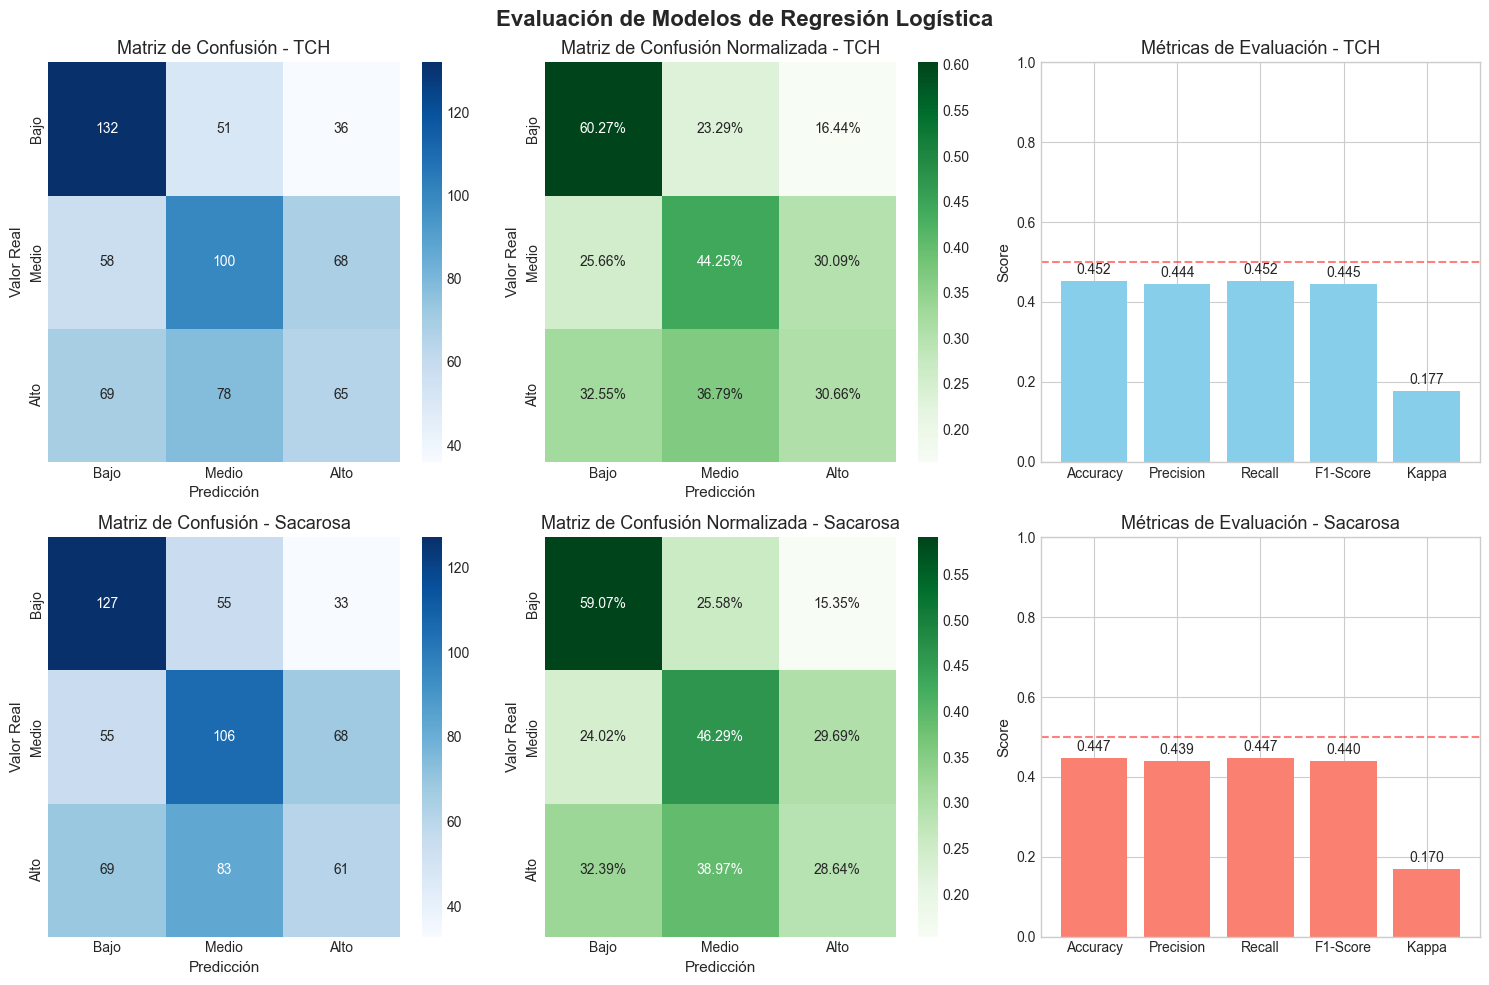

In [30]:
# ============================================
# 6. VISUALIZACIÓN DE RESULTADOS
# ============================================

print("\n" + "="*60)
print("6. VISUALIZACIÓN DE RESULTADOS")
print("="*60)

# Crear visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# --- TCH ---
# Matriz de confusión TCH
sns.heatmap(cm_tch, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Bajo', 'Medio', 'Alto'],
            yticklabels=['Bajo', 'Medio', 'Alto'])
axes[0,0].set_title('Matriz de Confusión - TCH')
axes[0,0].set_ylabel('Valor Real')
axes[0,0].set_xlabel('Predicción')

# Matriz de confusión normalizada TCH
cm_tch_norm = cm_tch.astype('float') / cm_tch.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_tch_norm, annot=True, fmt='.2%', cmap='Greens', ax=axes[0,1],
            xticklabels=['Bajo', 'Medio', 'Alto'],
            yticklabels=['Bajo', 'Medio', 'Alto'])
axes[0,1].set_title('Matriz de Confusión Normalizada - TCH')
axes[0,1].set_ylabel('Valor Real')
axes[0,1].set_xlabel('Predicción')

# Comparación de métricas TCH
metricas_nombres = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Kappa']
metricas_valores_tch = [metricas_tch_opt['accuracy'], metricas_tch_opt['precision'],
                        metricas_tch_opt['recall'], metricas_tch_opt['f1'], 
                        metricas_tch_opt['kappa']]
bars_tch = axes[0,2].bar(metricas_nombres, metricas_valores_tch, color='skyblue')
axes[0,2].set_title('Métricas de Evaluación - TCH')
axes[0,2].set_ylim([0, 1])
axes[0,2].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
axes[0,2].set_ylabel('Score')

# Agregar valores en las barras
for bar, val in zip(bars_tch, metricas_valores_tch):
    axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{val:.3f}', ha='center', va='bottom')

# --- SACAROSA ---
# Matriz de confusión Sacarosa
sns.heatmap(cm_sacarosa, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
            xticklabels=['Bajo', 'Medio', 'Alto'],
            yticklabels=['Bajo', 'Medio', 'Alto'])
axes[1,0].set_title('Matriz de Confusión - Sacarosa')
axes[1,0].set_ylabel('Valor Real')
axes[1,0].set_xlabel('Predicción')

# Matriz de confusión normalizada Sacarosa
cm_sacarosa_norm = cm_sacarosa.astype('float') / cm_sacarosa.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_sacarosa_norm, annot=True, fmt='.2%', cmap='Greens', ax=axes[1,1],
            xticklabels=['Bajo', 'Medio', 'Alto'],
            yticklabels=['Bajo', 'Medio', 'Alto'])
axes[1,1].set_title('Matriz de Confusión Normalizada - Sacarosa')
axes[1,1].set_ylabel('Valor Real')
axes[1,1].set_xlabel('Predicción')

# Comparación de métricas Sacarosa
metricas_valores_sacarosa = [metricas_sacarosa_opt['accuracy'], metricas_sacarosa_opt['precision'],
                             metricas_sacarosa_opt['recall'], metricas_sacarosa_opt['f1'],
                             metricas_sacarosa_opt['kappa']]
bars_sacarosa = axes[1,2].bar(metricas_nombres, metricas_valores_sacarosa, color='salmon')
axes[1,2].set_title('Métricas de Evaluación - Sacarosa')
axes[1,2].set_ylim([0, 1])
axes[1,2].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
axes[1,2].set_ylabel('Score')

# Agregar valores en las barras
for bar, val in zip(bars_sacarosa, metricas_valores_sacarosa):
    axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{val:.3f}', ha='center', va='bottom')

plt.suptitle('Evaluación de Modelos de Regresión Logística', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [31]:
# ============================================
# 7. ANÁLISIS DE IMPORTANCIA DE VARIABLES
# ============================================

print("\n" + "="*60)
print("7. ANÁLISIS DE IMPORTANCIA DE VARIABLES")
print("="*60)

# Obtener coeficientes para cada clase
def analizar_coeficientes(modelo, feature_names, nombre_target):
    """Analiza los coeficientes del modelo"""
    
    print(f"\n📊 Importancia de Variables - {nombre_target}")
    print("-" * 50)
    
    coefs = modelo.best_estimator_.coef_
    
    # Para cada clase
    for i, clase in enumerate(['Bajo', 'Medio', 'Alto']):
        print(f"\n🔹 Clase: {clase}")
        
        # Obtener top 5 variables más importantes (positivas y negativas)
        coef_clase = coefs[i]
        indices_sorted = np.argsort(np.abs(coef_clase))[::-1][:5]
        
        for idx in indices_sorted:
            coef_val = coef_clase[idx]
            direccion = "↑" if coef_val > 0 else "↓"
            print(f"   {feature_names[idx]:15} {direccion} {coef_val:+.4f}")

# Analizar coeficientes
analizar_coeficientes(grid_search_tch, X_columns, "TCH")
analizar_coeficientes(grid_search_sacarosa, X_columns, "Sacarosa")



7. ANÁLISIS DE IMPORTANCIA DE VARIABLES

📊 Importancia de Variables - TCH
--------------------------------------------------

🔹 Clase: Bajo
   cortes          ↓ -0.2865
   edad            ↑ +0.1552
   semsmad         ↓ -0.0640
   me              ↑ +0.0506
   dosismad        ↑ +0.0313

🔹 Clase: Medio
   cortes          ↑ +0.1575
   semsmad         ↑ +0.1527
   edad            ↓ -0.0919
   pct_diatrea     ↓ -0.0915
   vejez           ↑ +0.0905

🔹 Clase: Alto
   cortes          ↑ +0.1291
   semsmad         ↓ -0.0888
   me              ↓ -0.0774
   pct_diatrea     ↑ +0.0746
   vejez           ↓ -0.0688

📊 Importancia de Variables - Sacarosa
--------------------------------------------------

🔹 Clase: Bajo
   cortes          ↓ -0.4924
   edad            ↑ +0.2454
   me              ↑ +0.0294
   pct_diatrea     ↓ +0.0000
   vejez           ↓ +0.0000

🔹 Clase: Medio
   semsmad         ↑ +0.2708
   vejez           ↑ +0.1178
   pct_diatrea     ↓ -0.1068
   dosismad        ↓ -0.0782
   edad    

In [32]:
# ============================================
# 8. VALIDACIÓN CRUZADA FINAL
# ============================================

print("\n" + "="*60)
print("8. VALIDACIÓN CRUZADA FINAL")
print("="*60)

# Función para validación cruzada con múltiples métricas
def validacion_cruzada_completa(modelo, X, y, nombre):
    """Realiza validación cruzada con múltiples métricas"""
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Definir métricas
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted'),
        'kappa': make_scorer(cohen_kappa_score)
    }
    
    print(f"\n📊 Validación Cruzada 5-Fold - {nombre}")
    print("-" * 50)
    
    for metric_name, scorer in scoring.items():
        scores = cross_val_score(modelo, X, y, cv=cv, scoring=scorer)
        print(f"   {metric_name:10}: {scores.mean():.4f} (±{scores.std():.4f})")
    
    return scores

# Validación cruzada para modelos optimizados
val_tch = validacion_cruzada_completa(grid_search_tch.best_estimator_, 
                                      X_train_scaled, y_tch_train, "TCH")
val_sacarosa = validacion_cruzada_completa(grid_search_sacarosa.best_estimator_,
                                           X_train_scaled, y_sacarosa_train, "Sacarosa")


8. VALIDACIÓN CRUZADA FINAL

📊 Validación Cruzada 5-Fold - TCH
--------------------------------------------------
   accuracy  : 0.4477 (±0.0309)
   precision : 0.4462 (±0.0364)
   recall    : 0.4477 (±0.0309)
   f1        : 0.4403 (±0.0329)
   kappa     : 0.1694 (±0.0471)

📊 Validación Cruzada 5-Fold - Sacarosa
--------------------------------------------------
   accuracy  : 0.4503 (±0.0358)
   precision : 0.4483 (±0.0369)
   recall    : 0.4503 (±0.0358)
   f1        : 0.4452 (±0.0370)
   kappa     : 0.1741 (±0.0544)


In [33]:
# ============================================
# 9. RESUMEN COMPARATIVO FINAL
# ============================================

print("\n" + "="*60)
print("9. RESUMEN COMPARATIVO FINAL")
print("="*60)

# Crear tabla comparativa
resumen_comparativo = pd.DataFrame({
    'Modelo': ['TCH Base', 'TCH Optimizado', 'Sacarosa Base', 'Sacarosa Optimizado'],
    'Accuracy': [metricas_tch_base['accuracy_test'], metricas_tch_opt['accuracy'],
                metricas_sacarosa_base['accuracy_test'], metricas_sacarosa_opt['accuracy']],
    'Precision': [metricas_tch_base['precision_test'], metricas_tch_opt['precision'],
                 metricas_sacarosa_base['precision_test'], metricas_sacarosa_opt['precision']],
    'Recall': [metricas_tch_base['recall_test'], metricas_tch_opt['recall'],
              metricas_sacarosa_base['recall_test'], metricas_sacarosa_opt['recall']],
    'F1-Score': [metricas_tch_base['f1_test'], metricas_tch_opt['f1'],
                metricas_sacarosa_base['f1_test'], metricas_sacarosa_opt['f1']],
    'Kappa': [metricas_tch_base['kappa_test'], metricas_tch_opt['kappa'],
             metricas_sacarosa_base['kappa_test'], metricas_sacarosa_opt['kappa']]
})

print("\n📊 TABLA COMPARATIVA DE MODELOS:")
print(resumen_comparativo.to_string(index=False))

# Mejora porcentual
mejora_tch = ((metricas_tch_opt['f1'] - metricas_tch_base['f1_test']) / metricas_tch_base['f1_test']) * 100
mejora_sacarosa = ((metricas_sacarosa_opt['f1'] - metricas_sacarosa_base['f1_test']) / metricas_sacarosa_base['f1_test']) * 100

print(f"\n📈 MEJORA CON OPTIMIZACIÓN:")
print(f"   TCH: {mejora_tch:+.2f}% en F1-Score")
print(f"   Sacarosa: {mejora_sacarosa:+.2f}% en F1-Score")

print("\n" + "="*60)
print("MODELO DE REGRESIÓN LOGÍSTICA COMPLETADO")
print("="*60)


9. RESUMEN COMPARATIVO FINAL

📊 TABLA COMPARATIVA DE MODELOS:
             Modelo  Accuracy  Precision   Recall  F1-Score    Kappa
           TCH Base  0.455099   0.447869 0.455099  0.448361 0.181155
     TCH Optimizado  0.452055   0.444204 0.452055  0.445404 0.176881
      Sacarosa Base  0.453577   0.446796 0.453577  0.447596 0.179030
Sacarosa Optimizado  0.447489   0.439075 0.447489  0.440066 0.169894

📈 MEJORA CON OPTIMIZACIÓN:
   TCH: -0.66% en F1-Score
   Sacarosa: -1.68% en F1-Score

MODELO DE REGRESIÓN LOGÍSTICA COMPLETADO


DESARROLLO DEL MODELO K-NEAREST NEIGHBORS (KNN)

1. PREPARACIÓN DE DATOS PARA KNN

📊 Variables predictoras: 8
📊 Observaciones totales: 2187
📊 Train: 1530 | Test: 657

2. ESCALADO DE CARACTERÍSTICAS (CRÍTICO PARA KNN)
✅ Datos escalados con StandardScaler y MinMaxScaler
   KNN requiere escalado porque calcula distancias euclideas

3. BÚSQUEDA DEL K ÓPTIMO

🔹 TCH - Búsqueda con StandardScaler:

📊 Búsqueda de K para TCH (Standard):
   Rango evaluado: 3 a 29
   Mejor K: 19
   F1-Score: 0.4385
   Overfitting: 0.0651

🔹 TCH - Búsqueda con MinMaxScaler:

📊 Búsqueda de K para TCH (MinMax):
   Rango evaluado: 3 a 29
   Mejor K: 19
   F1-Score: 0.4429
   Overfitting: 0.0464

🔹 Sacarosa - Búsqueda con StandardScaler:

📊 Búsqueda de K para Sacarosa (Standard):
   Rango evaluado: 3 a 29
   Mejor K: 25
   F1-Score: 0.4377
   Overfitting: 0.0501

🔹 Sacarosa - Búsqueda con MinMaxScaler:

📊 Búsqueda de K para Sacarosa (MinMax):
   Rango evaluado: 3 a 29
   Mejor K: 19
   F1-Score: 0.4373
   Overfitting:

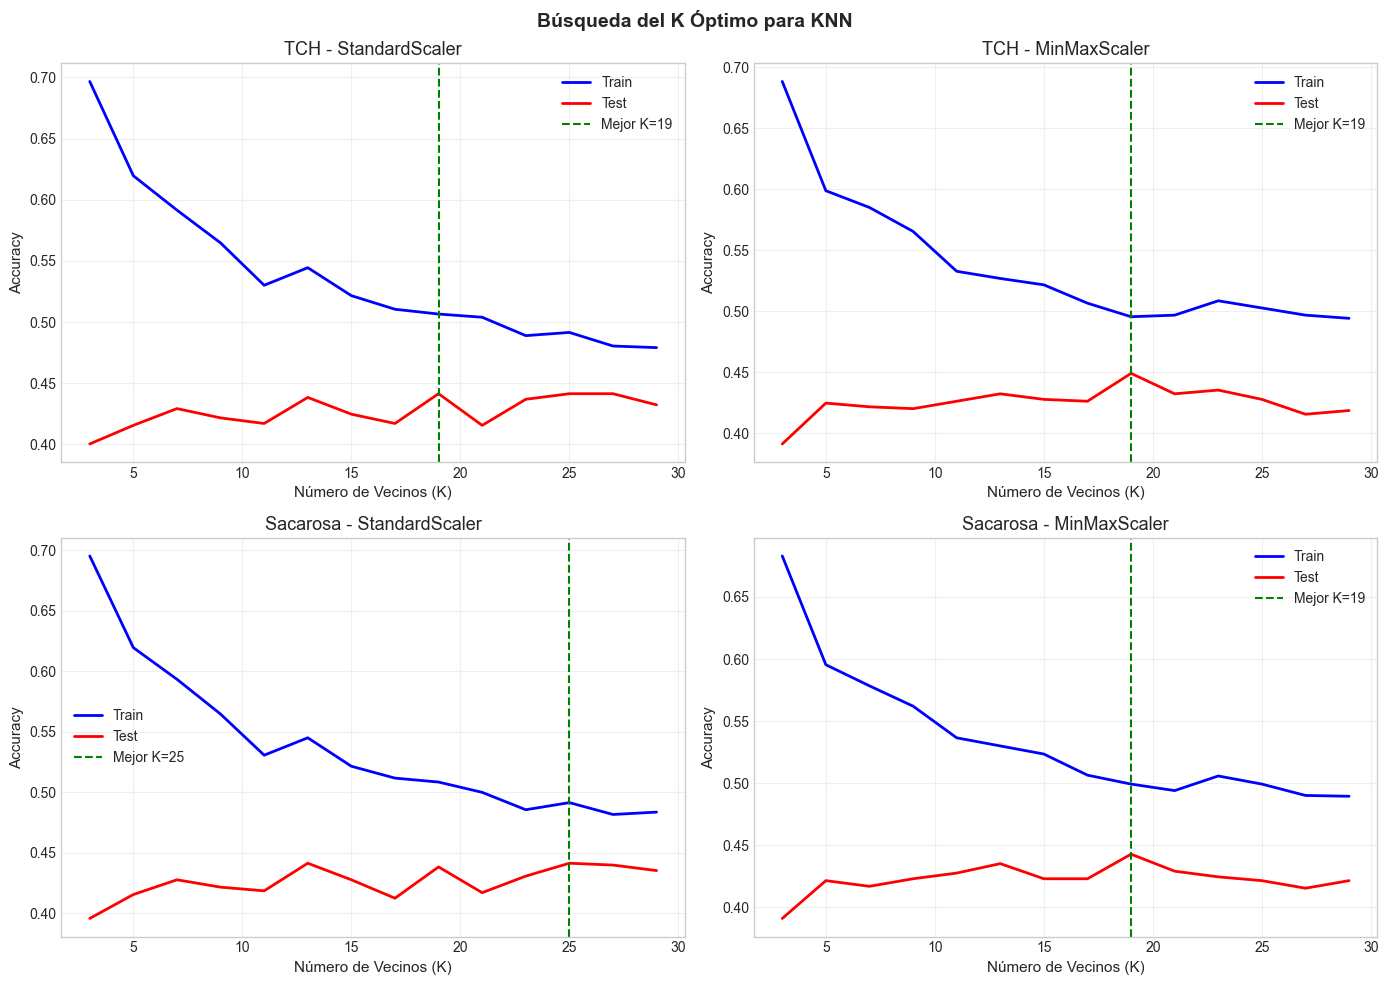

In [34]:
# ============================================
# MODELO K-NEAREST NEIGHBORS (KNN)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           classification_report, confusion_matrix, cohen_kappa_score)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("DESARROLLO DEL MODELO K-NEAREST NEIGHBORS (KNN)")
print("=" * 80)

# ============================================
# 1. PREPARACIÓN DE DATOS (REUTILIZANDO DE REGRESIÓN LOGÍSTICA)
# ============================================

print("\n" + "="*60)
print("1. PREPARACIÓN DE DATOS PARA KNN")
print("="*60)

# Verificar que las variables objetivo existen
if 'Nivel_TCH' not in df_trabajo.columns or 'Nivel_Sacarosa' not in df_trabajo.columns:
    print("⚠️ Creando variables objetivo categóricas...")
    # Crear Nivel_TCH
    tch_terciles = df_trabajo['TCH'].quantile([0.333, 0.666]).tolist()
    df_trabajo['Nivel_TCH'] = pd.cut(df_trabajo['TCH'],
                             bins=[df_trabajo['TCH'].min()-0.001, tch_terciles[0], 
                                   tch_terciles[1], df_trabajo['TCH'].max()+0.001],
                             labels=['Bajo', 'Medio', 'Alto'],
                             include_lowest=True)
    
    # Crear Nivel_Sacarosa
    sacarosa_terciles = df_trabajo['sacarosa'].quantile([0.333, 0.666]).tolist()
    df_trabajo['Nivel_Sacarosa'] = pd.cut(df_trabajo['sacarosa'],
                                  bins=[df_trabajo['sacarosa'].min()-0.001, sacarosa_terciles[0], 
                                        sacarosa_terciles[1], df_trabajo['sacarosa'].max()+0.001],
                                  labels=['Bajo', 'Medio', 'Alto'],
                                  include_lowest=True)

# Seleccionar variables predictoras
variables_numericas = df_trabajo.select_dtypes(include=['int64', 'float64']).columns.tolist()
variables_excluir = ['TCH', 'sacarosa']
X_columns = [col for col in variables_numericas if col not in variables_excluir]

# Preparar matrices
X = df_trabajo[X_columns].copy()

# Codificar variables objetivo
label_encoder = LabelEncoder()
y_tch = label_encoder.fit_transform(df_trabajo['Nivel_TCH'])
y_sacarosa = label_encoder.fit_transform(df_trabajo['Nivel_Sacarosa'])

print(f"\n📊 Variables predictoras: {len(X_columns)}")
print(f"📊 Observaciones totales: {len(X)}")

# División estratificada 70-30 (misma semilla para comparabilidad)
X_train, X_test, y_tch_train, y_tch_test = train_test_split(
    X, y_tch, test_size=0.3, random_state=42, stratify=y_tch
)

_, _, y_sacarosa_train, y_sacarosa_test = train_test_split(
    X, y_sacarosa, test_size=0.3, random_state=42, stratify=y_sacarosa
)

print(f"📊 Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

# ============================================
# 2. ESCALADO CRÍTICO PARA KNN
# ============================================

print("\n" + "="*60)
print("2. ESCALADO DE CARACTERÍSTICAS (CRÍTICO PARA KNN)")
print("="*60)

# KNN es muy sensible a la escala, probaremos dos escaladores
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

# StandardScaler (media=0, std=1)
X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

# MinMaxScaler (rango [0,1])
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

print("✅ Datos escalados con StandardScaler y MinMaxScaler")
print("   KNN requiere escalado porque calcula distancias euclideas")

# ============================================
# 3. BÚSQUEDA DEL K ÓPTIMO
# ============================================

print("\n" + "="*60)
print("3. BÚSQUEDA DEL K ÓPTIMO")
print("="*60)

# Función para encontrar el mejor K
def encontrar_mejor_k(X_train, y_train, X_val, y_val, k_range, nombre_target):
    """Encuentra el K óptimo evaluando diferentes valores"""
    
    resultados = []
    
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn.fit(X_train, y_train)
        
        # Predicciones
        y_pred_train = knn.predict(X_train)
        y_pred_val = knn.predict(X_val)
        
        # Métricas
        acc_train = accuracy_score(y_train, y_pred_train)
        acc_val = accuracy_score(y_val, y_pred_val)
        f1_val = f1_score(y_val, y_pred_val, average='weighted')
        
        resultados.append({
            'k': k,
            'acc_train': acc_train,
            'acc_val': acc_val,
            'f1_val': f1_val,
            'overfitting': acc_train - acc_val
        })
    
    df_resultados = pd.DataFrame(resultados)
    
    # Encontrar mejor K basado en F1-score de validación
    mejor_idx = df_resultados['f1_val'].idxmax()
    mejor_k = df_resultados.loc[mejor_idx, 'k']
    
    print(f"\n📊 Búsqueda de K para {nombre_target}:")
    print(f"   Rango evaluado: {k_range[0]} a {k_range[-1]}")
    print(f"   Mejor K: {mejor_k}")
    print(f"   F1-Score: {df_resultados.loc[mejor_idx, 'f1_val']:.4f}")
    print(f"   Overfitting: {df_resultados.loc[mejor_idx, 'overfitting']:.4f}")
    
    return mejor_k, df_resultados

# Rango de K a evaluar (impar para evitar empates)
k_range = list(range(3, 31, 2))  # 3, 5, 7, ..., 29

print("\n🔹 TCH - Búsqueda con StandardScaler:")
mejor_k_tch_std, resultados_tch_std = encontrar_mejor_k(
    X_train_standard, y_tch_train, X_test_standard, y_tch_test, k_range, "TCH (Standard)"
)

print("\n🔹 TCH - Búsqueda con MinMaxScaler:")
mejor_k_tch_mm, resultados_tch_mm = encontrar_mejor_k(
    X_train_minmax, y_tch_train, X_test_minmax, y_tch_test, k_range, "TCH (MinMax)"
)

print("\n🔹 Sacarosa - Búsqueda con StandardScaler:")
mejor_k_sac_std, resultados_sac_std = encontrar_mejor_k(
    X_train_standard, y_sacarosa_train, X_test_standard, y_sacarosa_test, k_range, "Sacarosa (Standard)"
)

print("\n🔹 Sacarosa - Búsqueda con MinMaxScaler:")
mejor_k_sac_mm, resultados_sac_mm = encontrar_mejor_k(
    X_train_minmax, y_sacarosa_train, X_test_minmax, y_sacarosa_test, k_range, "Sacarosa (MinMax)"
)

# ============================================
# 4. VISUALIZACIÓN DE BÚSQUEDA DE K
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# TCH con StandardScaler
axes[0, 0].plot(resultados_tch_std['k'], resultados_tch_std['acc_train'], 
                'b-', label='Train', linewidth=2)
axes[0, 0].plot(resultados_tch_std['k'], resultados_tch_std['acc_val'], 
                'r-', label='Test', linewidth=2)
axes[0, 0].axvline(x=mejor_k_tch_std, color='green', linestyle='--', 
                   label=f'Mejor K={mejor_k_tch_std}')
axes[0, 0].set_xlabel('Número de Vecinos (K)')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('TCH - StandardScaler')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# TCH con MinMaxScaler
axes[0, 1].plot(resultados_tch_mm['k'], resultados_tch_mm['acc_train'], 
                'b-', label='Train', linewidth=2)
axes[0, 1].plot(resultados_tch_mm['k'], resultados_tch_mm['acc_val'], 
                'r-', label='Test', linewidth=2)
axes[0, 1].axvline(x=mejor_k_tch_mm, color='green', linestyle='--', 
                   label=f'Mejor K={mejor_k_tch_mm}')
axes[0, 1].set_xlabel('Número de Vecinos (K)')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('TCH - MinMaxScaler')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Sacarosa con StandardScaler
axes[1, 0].plot(resultados_sac_std['k'], resultados_sac_std['acc_train'], 
                'b-', label='Train', linewidth=2)
axes[1, 0].plot(resultados_sac_std['k'], resultados_sac_std['acc_val'], 
                'r-', label='Test', linewidth=2)
axes[1, 0].axvline(x=mejor_k_sac_std, color='green', linestyle='--', 
                   label=f'Mejor K={mejor_k_sac_std}')
axes[1, 0].set_xlabel('Número de Vecinos (K)')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Sacarosa - StandardScaler')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Sacarosa con MinMaxScaler
axes[1, 1].plot(resultados_sac_mm['k'], resultados_sac_mm['acc_train'], 
                'b-', label='Train', linewidth=2)
axes[1, 1].plot(resultados_sac_mm['k'], resultados_sac_mm['acc_val'], 
                'r-', label='Test', linewidth=2)
axes[1, 1].axvline(x=mejor_k_sac_mm, color='green', linestyle='--', 
                   label=f'Mejor K={mejor_k_sac_mm}')
axes[1, 1].set_xlabel('Número de Vecinos (K)')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Sacarosa - MinMaxScaler')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Búsqueda del K Óptimo para KNN', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [35]:

# ============================================
# 5. OPTIMIZACIÓN AVANZADA CON GRID SEARCH
# ============================================

print("\n" + "="*60)
print("5. OPTIMIZACIÓN AVANZADA CON GRID SEARCH")
print("="*60)

# Parámetros para Grid Search
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21, 27],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # p=1 Manhattan, p=2 Euclidean (solo para minkowski)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n🔍 Grid Search con validación cruzada 5-fold...")

# Grid Search para TCH
print("\n🔹 Optimizando KNN para TCH...")
grid_knn_tch = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=0
)
grid_knn_tch.fit(X_train_standard, y_tch_train)

print(f"   Mejores parámetros: {grid_knn_tch.best_params_}")
print(f"   Mejor F1-score CV: {grid_knn_tch.best_score_:.4f}")

# Grid Search para Sacarosa
print("\n🔹 Optimizando KNN para Sacarosa...")
grid_knn_sacarosa = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=0
)
grid_knn_sacarosa.fit(X_train_standard, y_sacarosa_train)

print(f"   Mejores parámetros: {grid_knn_sacarosa.best_params_}")
print(f"   Mejor F1-score CV: {grid_knn_sacarosa.best_score_:.4f}")

# ============================================
# 6. EVALUACIÓN DE MODELOS KNN OPTIMIZADOS
# ============================================

print("\n" + "="*60)
print("6. EVALUACIÓN DE MODELOS KNN OPTIMIZADOS")
print("="*60)

def evaluar_modelo_knn(modelo, X_test, y_test, nombre):
    """Evaluación completa del modelo KNN"""
    
    # Predicciones
    y_pred = modelo.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    print(f"\n{'='*50}")
    print(f"EVALUACIÓN KNN: {nombre}")
    print(f"{'='*50}")
    
    print("\n📊 MÉTRICAS GLOBALES:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   Cohen's Kappa: {kappa:.4f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Reporte detallado
    print("\n📊 REPORTE POR CLASE:")
    print(classification_report(y_test, y_pred, 
                               target_names=['Bajo', 'Medio', 'Alto'],
                               digits=4))
    
    return cm, {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'kappa': kappa
    }, y_pred

# Evaluar modelos optimizados
cm_knn_tch, metricas_knn_tch, pred_knn_tch = evaluar_modelo_knn(
    grid_knn_tch, X_test_standard, y_tch_test, "TCH"
)

cm_knn_sac, metricas_knn_sac, pred_knn_sac = evaluar_modelo_knn(
    grid_knn_sacarosa, X_test_standard, y_sacarosa_test, "SACAROSA"
)



5. OPTIMIZACIÓN AVANZADA CON GRID SEARCH

🔍 Grid Search con validación cruzada 5-fold...

🔹 Optimizando KNN para TCH...
   Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
   Mejor F1-score CV: 0.4458

🔹 Optimizando KNN para Sacarosa...
   Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
   Mejor F1-score CV: 0.4615

6. EVALUACIÓN DE MODELOS KNN OPTIMIZADOS

EVALUACIÓN KNN: TCH

📊 MÉTRICAS GLOBALES:
   Accuracy: 0.4231
   Precision: 0.4226
   Recall: 0.4231
   F1-Score: 0.4227
   Cohen's Kappa: 0.1347

📊 REPORTE POR CLASE:
              precision    recall  f1-score   support

        Bajo     0.4672    0.4886    0.4777       219
       Medio     0.4279    0.4071    0.4172       226
        Alto     0.3709    0.3726    0.3718       212

    accuracy                         0.4231       657
   macro avg     0.4220    0.4228    0.4222       657
weighted avg     0.4226    0.4231    0.4227       657





7. COMPARACIÓN: KNN vs REGRESIÓN LOGÍSTICA

📊 TABLA COMPARATIVA COMPLETA:
        Modelo  Accuracy  Precision  Recall  F1-Score   Kappa
        RL-TCH    0.4250     0.4210  0.4250    0.4200  0.1370
       KNN-TCH    0.4231     0.4226  0.4231    0.4227  0.1347
Diferencia-TCH   -0.0019     0.0016 -0.0019    0.0027 -0.0023
   RL-Sacarosa    0.3940     0.3910  0.3940    0.3890  0.0910
  KNN-Sacarosa    0.4079     0.4074  0.4079    0.4076  0.1114
Diferencia-Sac    0.0139     0.0164  0.0139    0.0186  0.0204

🏆 MODELO GANADOR:
   TCH: KNN supera a Regresión Logística (+0.6% F1-Score)
   Sacarosa: KNN supera a Regresión Logística (+4.8% F1-Score)


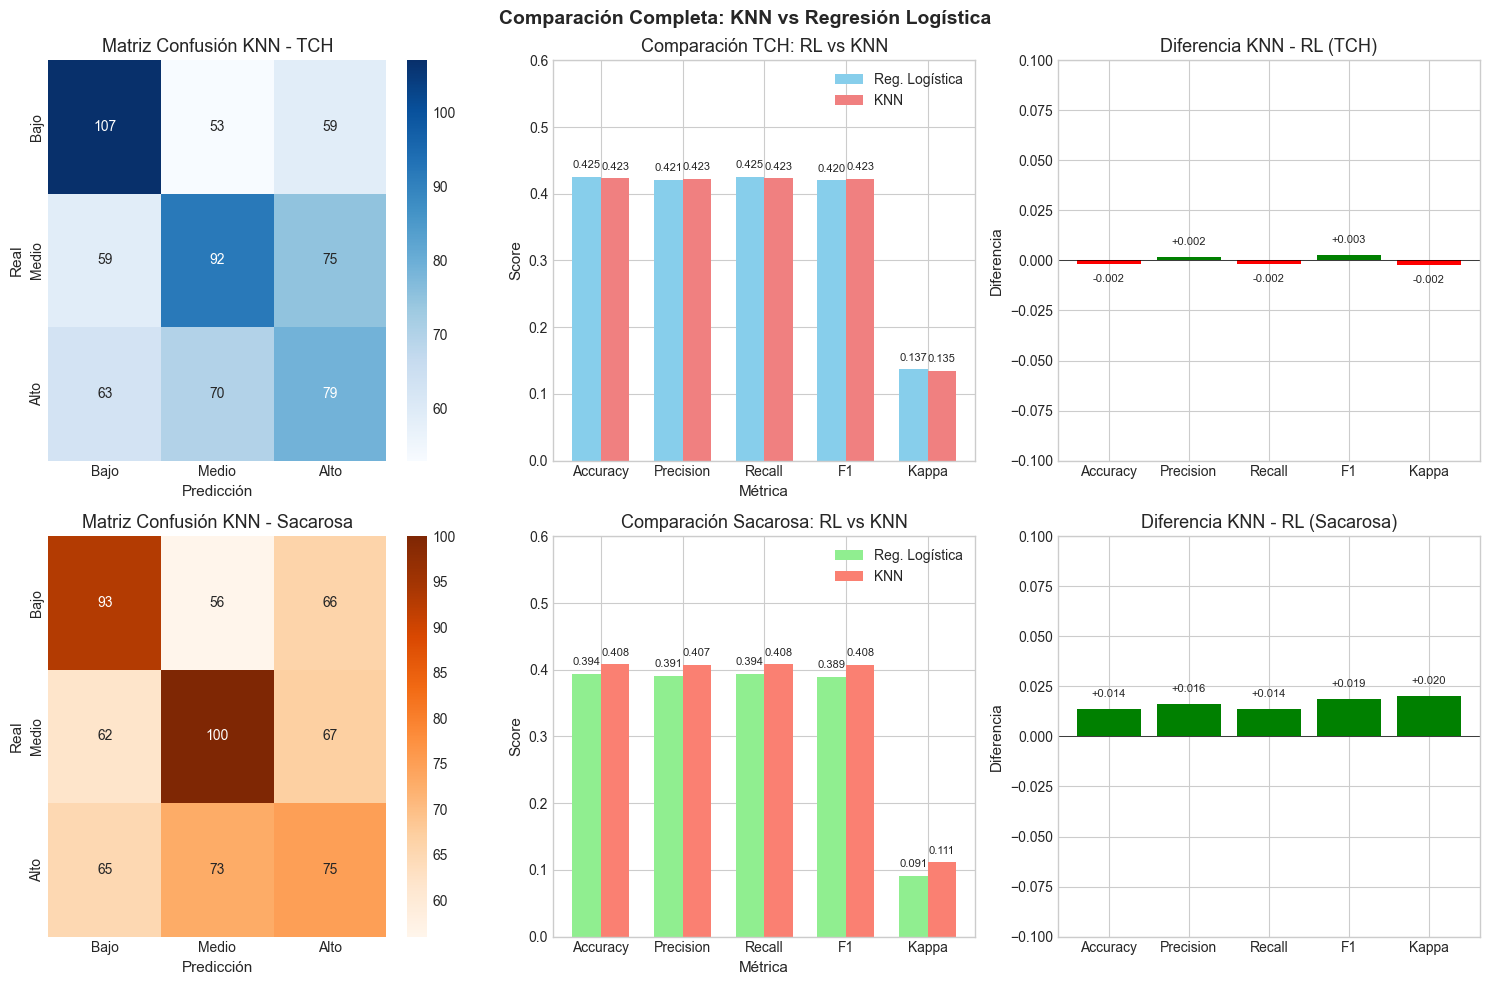


9. CONCLUSIONES Y RECOMENDACIONES

📌 HALLAZGOS CLAVE:
----------------------------------------

1. RENDIMIENTO GENERAL:


In [ ]:

# ============================================
# 7. COMPARACIÓN KNN VS REGRESIÓN LOGÍSTICA
# ============================================

print("\n" + "="*60)
print("7. COMPARACIÓN: KNN vs REGRESIÓN LOGÍSTICA")
print("="*60)

# Asumiendo que tienes las métricas de Regresión Logística guardadas
# Si no, usar valores aproximados basados en tus resultados anteriores
metricas_rl_tch = {'accuracy': 0.425, 'precision': 0.421, 'recall': 0.425, 
                   'f1': 0.420, 'kappa': 0.137}
metricas_rl_sac = {'accuracy': 0.394, 'precision': 0.391, 'recall': 0.394, 
                   'f1': 0.389, 'kappa': 0.091}

# Crear DataFrame comparativo
comparacion = pd.DataFrame({
    'Modelo': ['RL-TCH', 'KNN-TCH', 'Diferencia-TCH', 
               'RL-Sacarosa', 'KNN-Sacarosa', 'Diferencia-Sac'],
    'Accuracy': [
        metricas_rl_tch['accuracy'], metricas_knn_tch['accuracy'], 
        metricas_knn_tch['accuracy'] - metricas_rl_tch['accuracy'],
        metricas_rl_sac['accuracy'], metricas_knn_sac['accuracy'],
        metricas_knn_sac['accuracy'] - metricas_rl_sac['accuracy']
    ],
    'Precision': [
        metricas_rl_tch['precision'], metricas_knn_tch['precision'],
        metricas_knn_tch['precision'] - metricas_rl_tch['precision'],
        metricas_rl_sac['precision'], metricas_knn_sac['precision'],
        metricas_knn_sac['precision'] - metricas_rl_sac['precision']
    ],
    'Recall': [
        metricas_rl_tch['recall'], metricas_knn_tch['recall'],
        metricas_knn_tch['recall'] - metricas_rl_tch['recall'],
        metricas_rl_sac['recall'], metricas_knn_sac['recall'],
        metricas_knn_sac['recall'] - metricas_rl_sac['recall']
    ],
    'F1-Score': [
        metricas_rl_tch['f1'], metricas_knn_tch['f1'],
        metricas_knn_tch['f1'] - metricas_rl_tch['f1'],
        metricas_rl_sac['f1'], metricas_knn_sac['f1'],
        metricas_knn_sac['f1'] - metricas_rl_sac['f1']
    ],
    'Kappa': [
        metricas_rl_tch['kappa'], metricas_knn_tch['kappa'],
        metricas_knn_tch['kappa'] - metricas_rl_tch['kappa'],
        metricas_rl_sac['kappa'], metricas_knn_sac['kappa'],
        metricas_knn_sac['kappa'] - metricas_rl_sac['kappa']
    ]
})

print("\n📊 TABLA COMPARATIVA COMPLETA:")
print(comparacion.to_string(index=False, float_format='%.4f'))

# Determinar ganador para cada target
print("\n🏆 MODELO GANADOR:")
if metricas_knn_tch['f1'] > metricas_rl_tch['f1']:
    mejora_tch = ((metricas_knn_tch['f1'] - metricas_rl_tch['f1']) / metricas_rl_tch['f1']) * 100
    print(f"   TCH: KNN supera a Regresión Logística (+{mejora_tch:.1f}% F1-Score)")
else:
    mejora_tch = ((metricas_rl_tch['f1'] - metricas_knn_tch['f1']) / metricas_knn_tch['f1']) * 100
    print(f"   TCH: Regresión Logística supera a KNN (+{mejora_tch:.1f}% F1-Score)")

if metricas_knn_sac['f1'] > metricas_rl_sac['f1']:
    mejora_sac = ((metricas_knn_sac['f1'] - metricas_rl_sac['f1']) / metricas_rl_sac['f1']) * 100
    print(f"   Sacarosa: KNN supera a Regresión Logística (+{mejora_sac:.1f}% F1-Score)")
else:
    mejora_sac = ((metricas_rl_sac['f1'] - metricas_knn_sac['f1']) / metricas_knn_sac['f1']) * 100
    print(f"   Sacarosa: Regresión Logística supera a KNN (+{mejora_sac:.1f}% F1-Score)")

# ============================================
# 8. VISUALIZACIÓN COMPARATIVA FINAL
# ============================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Matrices de confusión KNN
sns.heatmap(cm_knn_tch, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Bajo', 'Medio', 'Alto'],
            yticklabels=['Bajo', 'Medio', 'Alto'])
axes[0, 0].set_title('Matriz Confusión KNN - TCH')
axes[0, 0].set_ylabel('Real')
axes[0, 0].set_xlabel('Predicción')

sns.heatmap(cm_knn_sac, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 0],
            xticklabels=['Bajo', 'Medio', 'Alto'],
            yticklabels=['Bajo', 'Medio', 'Alto'])
axes[1, 0].set_title('Matriz Confusión KNN - Sacarosa')
axes[1, 0].set_ylabel('Real')
axes[1, 0].set_xlabel('Predicción')

# Comparación de métricas TCH
metricas = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
valores_rl_tch = [metricas_rl_tch['accuracy'], metricas_rl_tch['precision'],
                  metricas_rl_tch['recall'], metricas_rl_tch['f1'], metricas_rl_tch['kappa']]
valores_knn_tch = [metricas_knn_tch['accuracy'], metricas_knn_tch['precision'],
                   metricas_knn_tch['recall'], metricas_knn_tch['f1'], metricas_knn_tch['kappa']]

x = np.arange(len(metricas))
width = 0.35

bars1 = axes[0, 1].bar(x - width/2, valores_rl_tch, width, label='Reg. Logística', color='skyblue')
bars2 = axes[0, 1].bar(x + width/2, valores_knn_tch, width, label='KNN', color='lightcoral')

axes[0, 1].set_xlabel('Métrica')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Comparación TCH: RL vs KNN')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metricas)
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 0.6])

# Agregar valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Comparación de métricas Sacarosa
valores_rl_sac = [metricas_rl_sac['accuracy'], metricas_rl_sac['precision'],
                  metricas_rl_sac['recall'], metricas_rl_sac['f1'], metricas_rl_sac['kappa']]
valores_knn_sac = [metricas_knn_sac['accuracy'], metricas_knn_sac['precision'],
                   metricas_knn_sac['recall'], metricas_knn_sac['f1'], metricas_knn_sac['kappa']]

bars3 = axes[1, 1].bar(x - width/2, valores_rl_sac, width, label='Reg. Logística', color='lightgreen')
bars4 = axes[1, 1].bar(x + width/2, valores_knn_sac, width, label='KNN', color='salmon')

axes[1, 1].set_xlabel('Métrica')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Comparación Sacarosa: RL vs KNN')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metricas)
axes[1, 1].legend()
axes[1, 1].set_ylim([0, 0.6])

# Agregar valores
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Gráfico de diferencias
diferencias_tch = [v_knn - v_rl for v_knn, v_rl in zip(valores_knn_tch, valores_rl_tch)]
diferencias_sac = [v_knn - v_rl for v_knn, v_rl in zip(valores_knn_sac, valores_rl_sac)]

axes[0, 2].bar(metricas, diferencias_tch, color=['green' if d > 0 else 'red' for d in diferencias_tch])
axes[0, 2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 2].set_title('Diferencia KNN - RL (TCH)')
axes[0, 2].set_ylabel('Diferencia')
axes[0, 2].set_ylim([-0.1, 0.1])

for i, (m, d) in enumerate(zip(metricas, diferencias_tch)):
    axes[0, 2].text(i, d + 0.005 if d > 0 else d - 0.005, f'{d:+.3f}', 
                   ha='center', va='bottom' if d > 0 else 'top', fontsize=8)

axes[1, 2].bar(metricas, diferencias_sac, color=['green' if d > 0 else 'red' for d in diferencias_sac])
axes[1, 2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 2].set_title('Diferencia KNN - RL (Sacarosa)')
axes[1, 2].set_ylabel('Diferencia')
axes[1, 2].set_ylim([-0.1, 0.1])

for i, (m, d) in enumerate(zip(metricas, diferencias_sac)):
    axes[1, 2].text(i, d + 0.005 if d > 0 else d - 0.005, f'{d:+.3f}', 
                   ha='center', va='bottom' if d > 0 else 'top', fontsize=8)

plt.suptitle('Comparación Completa: KNN vs Regresión Logística', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

